In [2]:
!pip install torch
!pip install torch-geometric
!pip install pysmiles
!pip install rdkit
!pip install transformers torch


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pysmiles import read_smiles
import pandas as pd
import logging
from tqdm import tqdm
import torch
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data
from google.colab import drive
from typing import Optional
drive.mount('/content/gdrive')

logging.getLogger('pysmiles').setLevel(logging.CRITICAL)

Mounted at /content/gdrive


# Clean Datasets

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('gdrive/My Drive/Base_GNN_Solubility/curated_solubility_dataset.csv') #read dataset (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8)
df = df[~df['SMILES'].str.contains('.', regex=False)]
df.reset_index(drop=True, inplace=True)
# df['Solubility'] = np.exp(df['Solubility'])
X_smiles = list(df['SMILES']) #get smiles strings from file
Y = np.asarray(df['Solubility']) #get solubility values from file
df = df.drop_duplicates()
df

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.000000,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996,511.229248
1,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.000000,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782,202.661065
2,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.000000,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427,769.899934
3,A-10,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.000000,1,G1,118.179,...,1.0,46.0,1.0,0.0,0.0,1.0,0.00,55.836626,3.070761,211.033225
4,A-11,3-(3-ethylcyclopentyl)propanoic acid,InChI=1S/C10H18O2/c1-2-8-3-4-9(7-8)5-6-10(11)1...,WVRFSLWCFASCIS-UHFFFAOYSA-N,CCC1CCC(CCC(O)=O)C1,-3.286116,0.000000,1,G1,170.252,...,4.0,70.0,0.0,1.0,1.0,1.0,37.30,73.973655,2.145839,153.917569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8879,I-84,tetracaine,InChI=1S/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9...,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,0.000000,1,G1,264.369,...,8.0,106.0,1.0,0.0,0.0,1.0,41.57,115.300645,2.394548,374.236893
8880,I-85,tetracycline,InChI=1S/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(...,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,0.000000,1,G1,444.440,...,2.0,170.0,1.0,0.0,3.0,4.0,181.62,182.429237,2.047922,1148.584975
8881,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,G5,150.221,...,1.0,60.0,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720,251.049732
8882,I-93,verapamil,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,0.000000,1,G1,454.611,...,13.0,180.0,2.0,0.0,0.0,2.0,63.95,198.569223,2.023333,938.203977


# Dataset
1. AqSolDB (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8)
2. OChem (https://ochem.eu/login/show.do?render-mode=full)
3. BigSolDB (https://zenodo.org/records/6984601)



# AqSolDB

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('gdrive/My Drive/Base_GNN_Solubility/curated_solubility_dataset.csv') #read dataset (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8)
df = df[~df['SMILES'].str.contains('.', regex=False)]
df.reset_index(drop=True, inplace=True)
# df['Solubility'] = np.exp(df['Solubility'])
X_smiles = list(df['SMILES']) #get smiles strings from file
Y = np.asarray(df['Solubility']) #get solubility values from file

columns_to_normalize = [
    "MolWt",
    "MolLogP",
    "MolMR",
    "HeavyAtomCount",
    "NumHAcceptors",
    "NumHDonors",
    "NumHeteroatoms",
    "NumRotatableBonds"]

scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


def val_to_class(val):
    if val < -3.65: #insoluble
        return [1, 0, 0]
    elif val < -1.69: #slightly soluble
        return [0, 1, 0]
    else: #soluble
        return [0, 0, 1]

# AttentiveFP (with edge features)

In [ ]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool, global_mean_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Proposed New Architecture

# New

In [ ]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool, global_mean_pool, SAGEConv
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)

class SimpleAttention(nn.Module):
    def __init__(self, input_dim):
        super(SimpleAttention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(input_dim))

    def forward(self, pooled_output):
        # Calculate attention scores as a dot product
        scores = torch.matmul(pooled_output, self.attention_weights)

        # Apply softmax to get attention weights
        att_weights = F.softmax(scores, dim=0)

        # Weighted output
        out_weighted = att_weights * pooled_output
        return out_weighted

class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = SAGEConv(hidden_channels, hidden_channels, aggr = 'sum')
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = SAGEConv(hidden_channels, hidden_channels, aggr = 'sum')
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)
        self.attention = SimpleAttention(hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        # out = global_add_pool(x, batch).relu_()
        # for t in range(self.num_timesteps):
        #     h = F.elu_(self.mol_conv((x, out), edge_index))
        #     h = F.dropout(h, p=self.dropout, training=self.training)
        #     out = self.mol_gru(h, out).relu_()


        out = global_add_pool(x, batch).relu()

        for t in range(self.num_timesteps):
            h = F.elu(self.mol_conv((x, out), edge_index))
            # h = self.batch_norm(h)  # Batch normalization
            h = F.dropout(h, p=self.dropout, training=self.training)

            # Attention mechanism
            out = F.softmax(self.attention(out), dim=0)

            # Residual connection
            out = self.mol_gru(h, out).relu() + out

        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# GPSConv

In [ ]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, GPSConv, MessagePassing, global_add_pool, global_mean_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GPSConv(hidden_channels, GATConv)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            # conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# SuperGAT

In [ ]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool, global_mean_pool, SuperGATConv
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = SuperGATConv(hidden_channels, hidden_channels)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# ASAPooling

In [ ]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool, SAGPooling, ASAPooling
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.pool1 = ASAPooling(hidden_channels, ratio=0.5)
        self.pool2 = ASAPooling(hidden_channels, ratio=0.5)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # multiple pooling layers from N -> 1
        pool_output1 = self.pool1(x, edge_index, batch=batch)
        x1 = pool_output1[0]  # Pooled node features
        edge_index1 = pool_output1[1]  # New edge index
        batch1 = pool_output1[3]  # New batch indices

        # If you have a second pooling layer
        pool_output2 = self.pool2(x1, edge_index1, batch=batch1)  # Pass edge_attr as None if not used
        x2 = pool_output2[0]  # Pooled node features
        edge_index2 = pool_output2[1]  # New edge index
        batch2 = pool_output2[3]  # New batch indices

        # Apply global addition pooling to create graph-level representation
        graph_embedding = global_add_pool(x2, batch2)

        return self.lin2(graph_embedding)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

In [ ]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)
        self.weights = torch.nn.Parameter(torch.tensor([1.0, 1.0, 1.0], dtype=torch.float32))

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        # out = global_add_pool(x, batch).relu_()

        add_pool = global_add_pool(x, batch)
        mean_pool = global_mean_pool(x, batch)
        max_pool = global_max_pool(x, batch)

        out = (self.weights[0] * add_pool +
                         self.weights[1] * mean_pool +
                         self.weights[2] * max_pool).relu()



        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Simplified (only one graph pooling)

In [ ]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool, global_avg_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        # for t in range(self.num_timesteps):
        #     h = F.elu_(self.mol_conv((x, out), edge_index))
        #     h = F.dropout(h, p=self.dropout, training=self.training)
        #     out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Multiple poolings

In [ ]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool, SAGPooling
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.pool1 = SAGPooling(hidden_channels, ratio=0.5, GNN = GATConv)
        self.pool2 = SAGPooling(hidden_channels, ratio=0.5, GNN = GATConv)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # multiple pooling layers from N -> 1
        pool_output1 = self.pool1(x, edge_index, edge_attr=edge_attr, batch=batch)
        x1 = pool_output1[0]  # Pooled node features
        edge_index1 = pool_output1[1]  # New edge index
        batch1 = pool_output1[3]  # New batch indices

        # If you have a second pooling layer
        pool_output2 = self.pool2(x1, edge_index1, edge_attr=None, batch=batch1)  # Pass edge_attr as None if not used
        x2 = pool_output2[0]  # Pooled node features
        edge_index2 = pool_output2[1]  # New edge index
        batch2 = pool_output2[3]  # New batch indices

        # Apply global addition pooling to create graph-level representation
        graph_embedding = global_add_pool(x2, batch2)

        return self.lin2(graph_embedding)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# replace GATConv by GATv2Conv

In [ ]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATv2Conv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATv2Conv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Attentive FP (with edge features) + graph level features


In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels+8, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, graph_level_features,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Add supernode to original graph

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, TransformerConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)

        self.mol_conv = TransformerConv(hidden_channels, hidden_channels)

        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        new_edge_index = edge_index.detach().clone()
        new_edge_index += 1
        new_edges = torch.tensor([[0] * x.shape[0],
                          list(range(1, x.shape[0] + 1))],
                          dtype=torch.long)

        # Concatenate original edge_index with new_edges
        new_edge_index = torch.cat([new_edge_index, new_edges], dim=1)
        supernode = global_add_pool(x, batch).relu_()
        x = torch.cat([x, supernode], dim=0)

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, new_edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # # Molecule Embedding:
        # row = torch.arange(batch.size(0), device=batch.device)
        # edge_index = torch.stack([row, batch], dim=0)

        # out = global_add_pool(x, batch).relu_()
        # for t in range(self.num_timesteps):
        #     h = F.elu_(self.mol_conv((x, out), edge_index))
        #     h = F.dropout(h, p=self.dropout, training=self.training)
        #     out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(x[0].unsqueeze(0), p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Replace GATConv by TransformerConv

In [ ]:
from typing import Optional
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, TransformerConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = TransformerConv(hidden_channels, hidden_channels)

        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Improved one: Replace GRU by LSTM

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import LSTMCell, Linear, Parameter
from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim, dropout)
        self.lstm = LSTMCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_lstm = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_lstm.append(LSTMCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False
        self.mol_lstm = LSTMCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.lstm.reset_parameters()
        for conv, lstm in zip(self.atom_convs, self.atom_lstm):
            conv.reset_parameters()
            lstm.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_lstm.reset_parameters()
        self.lin2.reset_parameters()


    # def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
    #             batch: Tensor) -> Tensor:
    #     """"""  # noqa: D419
    #     # Atom Embedding:
    #     x = F.leaky_relu_(self.lin1(x))

    #     h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
    #     h = F.dropout(h, p=self.dropout, training=self.training)
    #     x = self.gru(h, x).relu_()

    #     for conv, gru in zip(self.atom_convs, self.atom_grus):
    #         h = conv(x, edge_index)
    #         h = F.elu(h)
    #         h = F.dropout(h, p=self.dropout, training=self.training)
    #         x = gru(h, x).relu()

    #     # Molecule Embedding:
    #     row = torch.arange(batch.size(0), device=batch.device)
    #     edge_index = torch.stack([row, batch], dim=0)

    #     out = global_add_pool(x, batch).relu_()
    #     for t in range(self.num_timesteps):
    #         h = F.elu_(self.mol_conv((x, out), edge_index))
    #         h = F.dropout(h, p=self.dropout, training=self.training)
    #         out = self.mol_gru(h, out).relu_()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)

        # Initialize hidden and cell states for the LSTM
        # hx = torch.zeros(x.size(0), self.hidden_channels, device=x.device)
        # cx = torch.zeros(x.size(0), self.hidden_channels, device=x.device)
        cx = x

        # # Using LSTMCell
        # hx, cx = self.lstm(h, (hx, cx))  # Update x with LSTM

        for conv, lstm in zip(self.atom_convs, self.atom_lstm):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x, cx = lstm(h, (x, cx))  # Update x with LSTM
            x = x.relu()

        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        cx = out

        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out, cx = self.mol_lstm(h, (out, cx))  # Update out with LSTM
            out = out.relu()
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')


# Improved Two: Add graph level features and attention of graph level embeddings + features

In [ ]:
class AttentionLayer(torch.nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.lin = Linear(in_channels, in_channels)
        self.att = Parameter(torch.empty(1, in_channels))
        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin.weight)
        zeros(self.att)

    def forward(self, features: Tensor) -> Tensor:
        scores = (self.lin(features) * self.att).sum(dim=-1)  # Compute attention scores
        # alpha = F.softmax(scores, dim=0)  # Compute softmax for attention weights
        alpha = F.softmax(scores, dim=0)
        return (features * alpha.unsqueeze(-1)).sum(dim=0)  # Weighted sum of features

from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATv2Conv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout
        self.attention_layer = AttentionLayer(hidden_channels + 8)
        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels+8, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, graph_level_features,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)

        out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        out = self.attention_layer(out)
        # print(out.shape)
        out = F.dropout(out, p=self.dropout, training=self.training)

        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# First try of Transformer


In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Linear, Parameter, TransformerEncoder, TransformerEncoderLayer

from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        alpha = self.edge_update(x, edge_index, edge_attr)  # Corrected line
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_i: Tensor, edge_index: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_i, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        x_i = F.leaky_relu_(self.lin1(x_i))  # This line ensures x_i is processed
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)
    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim, dropout)

        # Transformer Encoder Layer
        self.transformer_encoder_layer = TransformerEncoderLayer(
            d_model=hidden_channels,
            nhead=8,  # Adjust the number of attention heads as needed
            dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers - 1)

        self.atom_convs = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout, add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)

        self.mol_conv = GATConv(hidden_channels, hidden_channels, dropout=dropout, add_self_loops=False, negative_slope=0.01)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        for conv in self.atom_convs:
            conv.reset_parameters()
        self.mol_conv.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, batch: Tensor) -> Tensor:
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)

        # Reshape for transformer: (seq_len, batch_size, features)
        h = h.unsqueeze(0)  # Add sequence dimension
        h = self.transformer_encoder(h)  # Pass through transformer layers
        h = h.squeeze(0)  # Remove sequence dimension

        # Atom-level GAT layers
        for conv in self.atom_convs:
            h = F.elu_(conv(h, edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)

        # Molecule Embedding:
        out = global_add_pool(h, batch).relu_()

        # Molecule-level GAT layer
        out = F.elu_(self.mol_conv(out, edge_index))
        out = F.dropout(out, p=self.dropout, training=self.training)

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')


# Improved GRU

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax

# class EnhancedGRUCell(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(EnhancedGRUCell, self).__init__()
#         self.gru = nn.GRUCell(input_size, hidden_size)
#         self.layer_norm = nn.LayerNorm(hidden_size)

#     def reset_parameters(self):
#         self.gru.reset_parameters()  # Reset parameters of the underlying GRU

#     def forward(self, input: Tensor, hidden: Tensor) -> Tensor:
#         hidden = self.gru(input, hidden)
#         return self.layer_norm(hidden)


class EnhancedGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EnhancedGRUCell, self).__init__()
        self.gru = nn.GRUCell(input_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        # self.dropout = nn.Dropout(dropout_rate)

    def reset_parameters(self):
        self.gru.reset_parameters()

    def forward(self, input: Tensor, hidden: Tensor) -> Tensor:
        new_hidden = self.gru(input, hidden)
        new_hidden = self.layer_norm(new_hidden + hidden)  # Residual connection
        return new_hidden



class AttentiveFP(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = nn.Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim, dropout)
        self.gru = EnhancedGRUCell(hidden_channels, hidden_channels)  # Use enhanced GRU

        self.atom_convs = nn.ModuleList()
        self.atom_grus = nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout, add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(EnhancedGRUCell(hidden_channels, hidden_channels))  # Use enhanced GRU

        self.mol_conv = GATConv(hidden_channels, hidden_channels, dropout=dropout, add_self_loops=False, negative_slope=0.01)
        self.mol_gru = EnhancedGRUCell(hidden_channels, hidden_channels)  # Use enhanced GRU

        self.lin2 = nn.Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, batch: Tensor) -> Tensor:
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x)  # Use enhanced GRU
        x = F.relu(x)

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x)  # Use enhanced GRU
            x = F.relu(x)

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out)  # Use enhanced GRU
            out = F.relu(out)

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')


# Replace GATConv by GINConv

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GINConv, TransformerConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = TransformerConv(32, 8, heads=4)

            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))


        self.mol_conv = TransformerConv(32, 8, heads=4)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

In [ ]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATv2Conv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels+8, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, graph_level_features,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

# Featurization for AttentiveFP


In [ ]:
import os.path as osp
from math import sqrt
import torch
import torch.nn.functional as F
from rdkit import Chem
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import AttentiveFP

class GenFeatures:
    def __init__(self):
        # self.symbols = [
        #     'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br',
        #     'Te', 'I', 'At', 'other'
        # ]

        self.symbols = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',
            'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce',
            'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al',
            'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn',
            'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd',
            'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C', 'other']

        self.hybridizations = [
            Chem.rdchem.HybridizationType.S,
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            Chem.rdchem.HybridizationType.UNSPECIFIED,
            'other',
        ]



        self.stereos = [
            Chem.rdchem.BondStereo.STEREONONE,
            Chem.rdchem.BondStereo.STEREOANY,
            Chem.rdchem.BondStereo.STEREOZ,
            Chem.rdchem.BondStereo.STEREOE,
        ]

    def __call__(self, smiles, i):
        # Generate AttentiveFP features
        data = Data()
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)

        xs = []

        for atom in mol.GetAtoms():
          # Initialize the symbol vector
          symbol = [0.] * len(self.symbols)

          # Handle atom symbol
          atom_symbol = atom.GetSymbol()
          if atom_symbol in self.symbols:
              symbol[self.symbols.index(atom_symbol)] = 1.
          else:
              print(f"Unrecognized element: {atom_symbol}")  # Log the unrecognized element
              symbol[-1] = 1.  # Mark as 'other'

          # Degree of the atom
          degree = [0.] * 6  # Degree list can handle degrees 0-5
          atom_degree = atom.GetDegree()
          if atom_degree < len(degree):
              degree[atom_degree] = 1.

          # Formal charge and radical electrons
          formal_charge = atom.GetFormalCharge()
          radical_electrons = atom.GetNumRadicalElectrons()

          # Hybridization handling
          hybridization = [0.] * len(self.hybridizations)
          try:
              hybridization[self.hybridizations.index(atom.GetHybridization())] = 1.
          except ValueError:
              print(f"Unrecognized hybridization for atom {atom_symbol}: {atom.GetHybridization()}")
              hybridization[-1] = 1.  # Default to 'other'

          # Aromaticity
          aromaticity = 1. if atom.GetIsAromatic() else 0.

          # Hydrogens
          hydrogens = [0.] * 5  # Assuming hydrogens can be 0-4
          total_hydrogens = atom.GetTotalNumHs()
          if total_hydrogens < len(hydrogens):
              hydrogens[total_hydrogens] = 1.
          else:
              hydrogens[-1] = 1.  # Use 'other' if more than 4 hydrogens

          # Chirality
          chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
          chirality_type = [0.] * 2
          if atom.HasProp('_CIPCode'):
              cip_code = atom.GetProp('_CIPCode')
              if cip_code in ['R', 'S']:
                  chirality_type[['R', 'S'].index(cip_code)] = 1.

          # Construct the feature tensor
          x = torch.tensor(symbol + degree + [formal_charge] +
                          [radical_electrons] + hybridization +
                          [aromaticity] + hydrogens + [chirality] +
                          chirality_type)
          xs.append(x)



        data.x = torch.stack(xs, dim=0)
        # data.y = torch.tensor([val_to_class(Y[i])], dtype=torch.float)
        data.y = torch.tensor(Y[i], dtype=torch.float)

        edge_indices = []
        edge_attrs = []
        for bond in mol.GetBonds():
            edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
            edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]

            bond_type = bond.GetBondType()
            single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
            double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
            triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
            aromatic = 1. if bond_type == Chem.rdchem.BondType.AROMATIC else 0.
            conjugation = 1. if bond.GetIsConjugated() else 0.
            ring = 1. if bond.IsInRing() else 0.
            stereo = [0.] * 4
            stereo[self.stereos.index(bond.GetStereo())] = 1.

            edge_attr = torch.tensor(
                [single, double, triple, aromatic, conjugation, ring] + stereo)

            edge_attrs += [edge_attr, edge_attr]

        if len(edge_attrs) == 0:
            data.edge_index = torch.zeros((2, 0), dtype=torch.long)
            data.edge_attr = torch.zeros((0, 10), dtype=torch.float)
        else:
            data.edge_index = torch.tensor(edge_indices).t().contiguous()
            data.edge_attr = torch.stack(edge_attrs, dim=0)

        # graph_level_features = pd.to_numeric(df.iloc[i, :][9:], errors='coerce').fillna(0).values

  #       graph_level_features = pd.to_numeric(df.iloc[0, :][["MolWt", "MolLogP", "MolMR", "HeavyAtomCount", "NumHAcceptors", "NumHDonors", "NumHeteroatoms",
  #  "NumRotatableBonds"]], errors='coerce').fillna(0).values
        # graph_level_features = pd.to_numeric(df.iloc[i, :][["T,K"]], errors='coerce').fillna(0).values
        # graph_level_features = torch.tensor(graph_level_features, dtype=torch.float)
        # data.graph_level_features = graph_level_features

        return data


pre_transform=GenFeatures()

data = list()

for i, smiles in tqdm(enumerate(X_smiles), total=len(X_smiles)):
    try:
        node_edge_featurization = pre_transform(smiles, i)
        data.append(node_edge_featurization)

    except Exception as e:
        print(f"Error processing {smiles}: {e}")

random.shuffle(data)
train = data[:int(len(data)*0.6)] #train set
val = data[int(len(data)*0.6):int(len(data)*0.8)]
test = data[int(len(data)*0.8):]

  4%|▍         | 412/9982 [00:00<00:16, 572.91it/s]

Unrecognized element: Re


[04:22:45] WARNING: not removing hydrogen atom without neighbors
[04:22:45] WARNING: not removing hydrogen atom without neighbors
  9%|▉         | 898/9982 [00:01<00:16, 561.59it/s][04:22:46] WARNING: not removing hydrogen atom without neighbors
[04:22:46] WARNING: not removing hydrogen atom without neighbors
 10%|▉         | 956/9982 [00:01<00:15, 566.69it/s][04:22:46] WARNING: not removing hydrogen atom without neighbors
[04:22:46] WARNING: not removing hydrogen atom without neighbors
 16%|█▌        | 1572/9982 [00:03<00:23, 353.80it/s][04:22:48] WARNING: not removing hydrogen atom without neighbors
[04:22:48] WARNING: not removing hydrogen atom without neighbors
[04:22:48] WARNING: not removing hydrogen atom without neighbors
[04:22:48] WARNING: not removing hydrogen atom without neighbors
 17%|█▋        | 1705/9982 [00:03<00:28, 290.90it/s][04:22:48] WARNING: not removing hydrogen atom without neighbors
[04:22:48] WARNING: not removing hydrogen atom without neighbors
 20%|█▉       

Unrecognized element: Ta


[04:22:51] WARNING: not removing hydrogen atom without neighbors
[04:22:51] WARNING: not removing hydrogen atom without neighbors
[04:22:51] WARNING: not removing hydrogen atom without neighbors
 33%|███▎      | 3256/9982 [00:06<00:12, 552.06it/s][04:22:51] WARNING: not removing hydrogen atom without neighbors
[04:22:51] WARNING: not removing hydrogen atom without neighbors
[04:22:51] WARNING: not removing hydrogen atom without neighbors
 36%|███▌      | 3594/9982 [00:07<00:17, 371.55it/s]

Unrecognized element: Ir


[04:22:52] WARNING: not removing hydrogen atom without neighbors
 37%|███▋      | 3683/9982 [00:07<00:15, 401.47it/s][04:22:52] WARNING: not removing hydrogen atom without neighbors


Unrecognized element: Be
Unrecognized element: Be


 41%|████▏     | 4136/9982 [00:08<00:08, 701.32it/s][04:22:53] WARNING: not removing hydrogen atom without neighbors
[04:22:53] WARNING: not removing hydrogen atom without neighbors
[04:22:53] WARNING: not removing hydrogen atom without neighbors
 62%|██████▏   | 6194/9982 [00:11<00:06, 630.04it/s][04:22:56] WARNING: not removing hydrogen atom without neighbors
[04:22:56] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 9982/9982 [00:17<00:00, 566.41it/s]


# Featurization for AttentiveFP + Graph-level Features

In [6]:
import os.path as osp
from math import sqrt
import torch
import torch.nn.functional as F
from rdkit import Chem
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import AttentiveFP

class GenFeatures:
    def __init__(self):
        self.symbols = [
            'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br',
            'Te', 'I', 'At', 'other'
        ]

        # self.symbols = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',
        #     'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce',
        #     'Zr', 'Ag', 'Ba', 'Be', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al', 'Re', 'Ta',
        #     'Ir','Be,','B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn',
        #     'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd',
        #     'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C', 'other']

        self.hybridizations = [
            Chem.rdchem.HybridizationType.S,
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            Chem.rdchem.HybridizationType.UNSPECIFIED,
            'other',
        ]



        self.stereos = [
            Chem.rdchem.BondStereo.STEREONONE,
            Chem.rdchem.BondStereo.STEREOANY,
            Chem.rdchem.BondStereo.STEREOZ,
            Chem.rdchem.BondStereo.STEREOE,
        ]

    def __call__(self, smiles, i):
        # Generate AttentiveFP features
        data = Data()
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)

        xs = []

        for atom in mol.GetAtoms():
          # Initialize the symbol vector
          symbol = [0.] * len(self.symbols)

          # Handle atom symbol
          atom_symbol = atom.GetSymbol()
          if atom_symbol in self.symbols:
              symbol[self.symbols.index(atom_symbol)] = 1.
          else:
              # print(f"Unrecognized element: {atom_symbol}")  # Log the unrecognized element
              symbol[-1] = 1.  # Mark as 'other'

          # Degree of the atom
          degree = [0.] * 6  # Degree list can handle degrees 0-5
          atom_degree = atom.GetDegree()
          if atom_degree < len(degree):
              degree[atom_degree] = 1.

          # Formal charge and radical electrons
          formal_charge = atom.GetFormalCharge()
          radical_electrons = atom.GetNumRadicalElectrons()

          # Hybridization handling
          hybridization = [0.] * len(self.hybridizations)
          try:
              hybridization[self.hybridizations.index(atom.GetHybridization())] = 1.
          except ValueError:
              print(f"Unrecognized hybridization for atom {atom_symbol}: {atom.GetHybridization()}")
              hybridization[-1] = 1.  # Default to 'other'

          # Aromaticity
          aromaticity = 1. if atom.GetIsAromatic() else 0.

          # Hydrogens
          hydrogens = [0.] * 5  # Assuming hydrogens can be 0-4
          total_hydrogens = atom.GetTotalNumHs()
          if total_hydrogens < len(hydrogens):
              hydrogens[total_hydrogens] = 1.
          else:
              hydrogens[-1] = 1.  # Use 'other' if more than 4 hydrogens

          # Chirality
          chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
          chirality_type = [0.] * 2
          if atom.HasProp('_CIPCode'):
              cip_code = atom.GetProp('_CIPCode')
              if cip_code in ['R', 'S']:
                  chirality_type[['R', 'S'].index(cip_code)] = 1.

          # Construct the feature tensor
          x = torch.tensor(symbol + degree + [formal_charge] +
                          [radical_electrons] + hybridization +
                          [aromaticity] + hydrogens + [chirality] +
                          chirality_type)
          xs.append(x)



        data.x = torch.stack(xs, dim=0)
        # data.y = torch.tensor([val_to_class(Y[i])], dtype=torch.float)
        data.y = torch.tensor(Y[i], dtype=torch.float)

        edge_indices = []
        edge_attrs = []
        for bond in mol.GetBonds():
            edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
            edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]

            bond_type = bond.GetBondType()
            single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
            double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
            triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
            aromatic = 1. if bond_type == Chem.rdchem.BondType.AROMATIC else 0.
            conjugation = 1. if bond.GetIsConjugated() else 0.
            ring = 1. if bond.IsInRing() else 0.
            stereo = [0.] * 4
            stereo[self.stereos.index(bond.GetStereo())] = 1.

            edge_attr = torch.tensor(
                [single, double, triple, aromatic, conjugation, ring] + stereo)

            edge_attrs += [edge_attr, edge_attr]

        if len(edge_attrs) == 0:
            data.edge_index = torch.zeros((2, 0), dtype=torch.long)
            data.edge_attr = torch.zeros((0, 10), dtype=torch.float)
        else:
            data.edge_index = torch.tensor(edge_indices).t().contiguous()
            data.edge_attr = torch.stack(edge_attrs, dim=0)

        # graph_level_features = pd.to_numeric(df.iloc[i, :][9:], errors='coerce').fillna(0).values

        graph_level_features = pd.to_numeric(df.iloc[i, :][["MolWt", "MolLogP", "MolMR", "HeavyAtomCount", "NumHAcceptors", "NumHDonors", "NumHeteroatoms",
   "NumRotatableBonds"]], errors='coerce').fillna(0).values
        graph_level_features = torch.tensor(graph_level_features, dtype=torch.float)
        data.graph_level_features = graph_level_features

        return data


pre_transform=GenFeatures()

data = list()

for i, smiles in tqdm(enumerate(X_smiles), total=len(X_smiles)):
    try:
        node_edge_featurization = pre_transform(smiles, i)
        data.append(node_edge_featurization)

    except Exception as e:
        print(f"Error processing {smiles}: {e}")

random.shuffle(data)
train = data[:int(len(data)*0.6)] #train set
val = data[int(len(data)*0.6):int(len(data)*0.8)]
test = data[int(len(data)*0.8):]

100%|██████████| 8884/8884 [00:32<00:00, 272.22it/s]


In [36]:
torch.save(train, 'gdrive/My Drive/Base_GNN_Solubility/train_data_AqsolDB_cleaned.pt')
torch.save(val, 'gdrive/My Drive/Base_GNN_Solubility/val_data_AqsolDB_cleaned.pt')
torch.save(test, 'gdrive/My Drive/Base_GNN_Solubility/test_data_AqsolDB_cleaned.pt')

In [ ]:
#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveFP(in_channels = 87, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
# CSE = CrossEntropyLoss() #define loss

In [ ]:
#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveFP(in_channels = 26, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
# CSE = CrossEntropyLoss() #define loss

# AttentiveFP with Edge Features Training

In [16]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool, global_mean_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))
        # print(x.shape)
        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        # print(h.shape)
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveFP(in_channels = 41, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
# CSE = CrossEntropyLoss() #define loss

In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 5330/5330 [01:44<00:00, 50.86it/s]


Epoch: 001, Average MAE: 1.13712
Validation MAE: 0.87527
Model improved! Saving model...


100%|██████████| 5330/5330 [01:39<00:00, 53.59it/s]


Epoch: 002, Average MAE: 0.88672
Validation MAE: 0.94778


100%|██████████| 5330/5330 [01:39<00:00, 53.59it/s]


Epoch: 003, Average MAE: 0.82123
Validation MAE: 0.79959
Model improved! Saving model...


100%|██████████| 5330/5330 [01:38<00:00, 53.89it/s]


Epoch: 004, Average MAE: 0.79515
Validation MAE: 0.81052


100%|██████████| 5330/5330 [01:42<00:00, 51.92it/s]


Epoch: 005, Average MAE: 0.76378
Validation MAE: 0.76806
Model improved! Saving model...


100%|██████████| 5330/5330 [01:43<00:00, 51.62it/s]


Epoch: 006, Average MAE: 0.74032
Validation MAE: 0.79624


 44%|████▍     | 2358/5330 [00:44<00:51, 58.02it/s]

In [19]:
from sklearn.metrics import r2_score

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        actual_values = data.y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

Test MAE: 0.70184
R-squared: 0.80482


# Proposed New Architecture

# Add ensemble global poolings

In [54]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)
        self.weights = torch.nn.Parameter(torch.tensor([1.0, 0.0, 0.0], dtype=torch.float32))

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        # out = global_add_pool(x, batch).relu_()

        add_pool = global_add_pool(x, batch)
        mean_pool = global_mean_pool(x, batch)
        max_pool = global_max_pool(x, batch)

        out = (self.weights[0] * add_pool +
                         self.weights[1] * mean_pool +
                         self.weights[2] * max_pool).relu()



        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')



  #set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveFP(in_channels = 41, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
# CSE = CrossEntropyLoss() #define loss

# GATv2

In [29]:
# from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import GRUCell, Linear, Parameter

from torch_geometric.nn import GATConv, GATv2Conv, MessagePassing, global_add_pool, global_mean_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        # edge_updater_type: (x: Tensor, edge_attr: Tensor)
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)

        # propagate_type: (x: Tensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    r"""The Attentive FP model for molecular representation learning from the
    `"Pushing the Boundaries of Molecular Representation for Drug Discovery
    with the Graph Attention Mechanism"
    <https://pubs.acs.org/doi/10.1021/acs.jmedchem.9b00959>`_ paper, based on
    graph attention mechanisms.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Hidden node feature dimensionality.
        out_channels (int): Size of each output sample.
        edge_dim (int): Edge feature dimensionality.
        num_layers (int): Number of GNN layers.
        num_timesteps (int): Number of iterative refinement steps for global
            readout.
        dropout (float, optional): Dropout probability. (default: :obj:`0.0`)

    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim,
                                  dropout)
        self.gru = GRUCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATv2Conv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_grus.append(GRUCell(hidden_channels, hidden_channels))

        self.mol_conv = GATv2Conv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False  # Cannot explain global pooling.
        self.mol_gru = GRUCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.gru.reset_parameters()
        for conv, gru in zip(self.atom_convs, self.atom_grus):
            conv.reset_parameters()
            gru.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_gru.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        """"""  # noqa: D419
        # Atom Embedding:
        x = F.leaky_relu_(self.lin1(x))
        # print(x.shape)
        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        # print(h.shape)
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru(h, x).relu_()

        for conv, gru in zip(self.atom_convs, self.atom_grus):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()

        # Molecule Embedding:
        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.mol_gru(h, out).relu_()

        # Predictor:
        #concatenate graph-level features to the output layer
        # out = torch.concat((out, graph_level_features.unsqueeze(0)), dim = -1)
        # out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')

#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveFP(in_channels = 41, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
# CSE = CrossEntropyLoss() #define loss

# LSTM (use cell state)

In [1]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import LSTMCell, Linear, Parameter
from torch_geometric.nn import GATConv, MessagePassing, global_add_pool, GATv2
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim, dropout)
        self.lstm = LSTMCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_lstm = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATConv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_lstm.append(LSTMCell(hidden_channels, hidden_channels))

        self.mol_conv = GATConv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False
        self.mol_lstm = LSTMCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.lstm.reset_parameters()
        for conv, lstm in zip(self.atom_convs, self.atom_lstm):
            conv.reset_parameters()
            lstm.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_lstm.reset_parameters()
        self.lin2.reset_parameters()


    # def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
    #             batch: Tensor) -> Tensor:
    #     """"""  # noqa: D419
    #     # Atom Embedding:
    #     x = F.leaky_relu_(self.lin1(x))

    #     h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
    #     h = F.dropout(h, p=self.dropout, training=self.training)
    #     x = self.gru(h, x).relu_()

    #     for conv, gru in zip(self.atom_convs, self.atom_grus):
    #         h = conv(x, edge_index)
    #         h = F.elu(h)
    #         h = F.dropout(h, p=self.dropout, training=self.training)
    #         x = gru(h, x).relu()

    #     # Molecule Embedding:
    #     row = torch.arange(batch.size(0), device=batch.device)
    #     edge_index = torch.stack([row, batch], dim=0)

    #     out = global_add_pool(x, batch).relu_()
    #     for t in range(self.num_timesteps):
    #         h = F.elu_(self.mol_conv((x, out), edge_index))
    #         h = F.dropout(h, p=self.dropout, training=self.training)
    #         out = self.mol_gru(h, out).relu_()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)

        # Initialize hidden and cell states for the LSTM
        # hx = torch.zeros(x.size(0), self.hidden_channels, device=x.device)
        # cx = torch.zeros(x.size(0), self.hidden_channels, device=x.device)
        cx = x

        # # Using LSTMCell
        # hx, cx = self.lstm(h, (hx, cx))  # Update x with LSTM

        for conv, lstm in zip(self.atom_convs, self.atom_lstm):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            # x, cx = lstm(h, (x, cx))  # Update x with LSTM
            cx, x = lstm(h, (cx, x))  # Update x with LSTM
            x = x.relu()

        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        cx = out

        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            # out, cx = self.mol_lstm(h, (out, cx))  # Update out with LSTM
            cx, out = self.mol_lstm(h, (cx, out))  # Update out with LSTM
            out = out.relu()
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')



#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveFP(in_channels = 41, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
# CSE = CrossEntropyLoss() #define loss

ModuleNotFoundError: No module named 'torch_geometric'

# LSTM (use hidden state)
# both GATv2 and LSTM

In [32]:
from typing import Optional

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import LSTMCell, Linear, Parameter
from torch_geometric.nn import GATConv, MessagePassing, global_add_pool
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import softmax


class GATEConv(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        edge_dim: int,
        dropout: float = 0.0,
    ):
        super().__init__(aggr='add', node_dim=0)

        self.dropout = dropout

        self.att_l = Parameter(torch.empty(1, out_channels))
        self.att_r = Parameter(torch.empty(1, in_channels))

        self.lin1 = Linear(in_channels + edge_dim, out_channels, False)
        self.lin2 = Linear(out_channels, out_channels, False)

        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.att_l)
        glorot(self.att_r)
        glorot(self.lin1.weight)
        glorot(self.lin2.weight)
        zeros(self.bias)

    def forward(self, x: Tensor, edge_index: Adj, edge_attr: Tensor) -> Tensor:
        alpha = self.edge_updater(edge_index, x=x, edge_attr=edge_attr)
        out = self.propagate(edge_index, x=x, alpha=alpha)
        out = out + self.bias
        return out

    def edge_update(self, x_j: Tensor, x_i: Tensor, edge_attr: Tensor,
                    index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        x_j = F.leaky_relu_(self.lin1(torch.cat([x_j, edge_attr], dim=-1)))
        alpha_j = (x_j @ self.att_l.t()).squeeze(-1)
        alpha_i = (x_i @ self.att_r.t()).squeeze(-1)
        alpha = alpha_j + alpha_i
        alpha = F.leaky_relu_(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha

    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return self.lin2(x_j) * alpha.unsqueeze(-1)


class AttentiveFP(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        edge_dim: int,
        num_layers: int,
        num_timesteps: int,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.num_layers = num_layers
        self.num_timesteps = num_timesteps
        self.dropout = dropout

        self.lin1 = Linear(in_channels, hidden_channels)

        self.gate_conv = GATEConv(hidden_channels, hidden_channels, edge_dim, dropout)
        self.lstm = LSTMCell(hidden_channels, hidden_channels)

        self.atom_convs = torch.nn.ModuleList()
        self.atom_lstm = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            conv = GATv2Conv(hidden_channels, hidden_channels, dropout=dropout,
                           add_self_loops=False, negative_slope=0.01)
            self.atom_convs.append(conv)
            self.atom_lstm.append(LSTMCell(hidden_channels, hidden_channels))

        self.mol_conv = GATv2Conv(hidden_channels, hidden_channels,
                                dropout=dropout, add_self_loops=False,
                                negative_slope=0.01)
        self.mol_conv.explain = False
        self.mol_lstm = LSTMCell(hidden_channels, hidden_channels)

        self.lin2 = Linear(hidden_channels, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.gate_conv.reset_parameters()
        self.lstm.reset_parameters()
        for conv, lstm in zip(self.atom_convs, self.atom_lstm):
            conv.reset_parameters()
            lstm.reset_parameters()
        self.mol_conv.reset_parameters()
        self.mol_lstm.reset_parameters()
        self.lin2.reset_parameters()


    # def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
    #             batch: Tensor) -> Tensor:
    #     """"""  # noqa: D419
    #     # Atom Embedding:
    #     x = F.leaky_relu_(self.lin1(x))

    #     h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
    #     h = F.dropout(h, p=self.dropout, training=self.training)
    #     x = self.gru(h, x).relu_()

    #     for conv, gru in zip(self.atom_convs, self.atom_grus):
    #         h = conv(x, edge_index)
    #         h = F.elu(h)
    #         h = F.dropout(h, p=self.dropout, training=self.training)
    #         x = gru(h, x).relu()

    #     # Molecule Embedding:
    #     row = torch.arange(batch.size(0), device=batch.device)
    #     edge_index = torch.stack([row, batch], dim=0)

    #     out = global_add_pool(x, batch).relu_()
    #     for t in range(self.num_timesteps):
    #         h = F.elu_(self.mol_conv((x, out), edge_index))
    #         h = F.dropout(h, p=self.dropout, training=self.training)
    #         out = self.mol_gru(h, out).relu_()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        x = F.leaky_relu_(self.lin1(x))

        h = F.elu_(self.gate_conv(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)

        # Initialize hidden and cell states for the LSTM
        # hx = torch.zeros(x.size(0), self.hidden_channels, device=x.device)
        # cx = torch.zeros(x.size(0), self.hidden_channels, device=x.device)
        cx = x

        # # Using LSTMCell
        # hx, cx = self.lstm(h, (hx, cx))  # Update x with LSTM

        for conv, lstm in zip(self.atom_convs, self.atom_lstm):
            h = conv(x, edge_index)
            h = F.elu(h)
            h = F.dropout(h, p=self.dropout, training=self.training)
            x, cx = lstm(h, (x, cx))  # Update x with LSTM
            # cx, x = lstm(h, (cx, x))  # Update x with LSTM
            x = x.relu()

        row = torch.arange(batch.size(0), device=batch.device)
        edge_index = torch.stack([row, batch], dim=0)

        out = global_add_pool(x, batch).relu_()
        cx = out

        for t in range(self.num_timesteps):
            h = F.elu_(self.mol_conv((x, out), edge_index))
            h = F.dropout(h, p=self.dropout, training=self.training)
            out, cx = self.mol_lstm(h, (out, cx))  # Update out with LSTM
            # cx, out = self.mol_lstm(h, (cx, out))  # Update out with LSTM
            out = out.relu()
        out = F.dropout(out, p=self.dropout, training=self.training)
        return self.lin2(out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'out_channels={self.out_channels}, '
                f'edge_dim={self.edge_dim}, '
                f'num_layers={self.num_layers}, '
                f'num_timesteps={self.num_timesteps}'
                f')')



#set up device and create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
# model = Net().to(device) #create network and send to the device memory
model = AttentiveFP(in_channels = 41, hidden_channels = 32, out_channels = 1, edge_dim = 10, num_layers = 3, num_timesteps = 3, dropout = 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
# CSE = CrossEntropyLoss() #define loss

In [21]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import r2_score

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        actual_values = data.y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

100%|██████████| 5330/5330 [01:35<00:00, 55.82it/s]


Epoch: 001, Average MAE: 1.21143
Validation MAE: 0.96381
Model improved! Saving model...


100%|██████████| 5330/5330 [01:33<00:00, 57.25it/s]


Epoch: 002, Average MAE: 0.93984
Validation MAE: 0.85257
Model improved! Saving model...


100%|██████████| 5330/5330 [01:30<00:00, 59.06it/s]


Epoch: 003, Average MAE: 0.85849
Validation MAE: 0.87104


100%|██████████| 5330/5330 [01:31<00:00, 58.38it/s]


Epoch: 004, Average MAE: 0.81036
Validation MAE: 0.81308
Model improved! Saving model...


100%|██████████| 5330/5330 [01:28<00:00, 60.37it/s]


Epoch: 005, Average MAE: 0.78440
Validation MAE: 0.79351
Model improved! Saving model...


100%|██████████| 5330/5330 [01:30<00:00, 59.11it/s]


Epoch: 006, Average MAE: 0.76806
Validation MAE: 0.73123
Model improved! Saving model...


100%|██████████| 5330/5330 [01:28<00:00, 59.95it/s]


Epoch: 007, Average MAE: 0.74768
Validation MAE: 0.71109
Model improved! Saving model...


100%|██████████| 5330/5330 [01:31<00:00, 58.27it/s]


Epoch: 008, Average MAE: 0.72475
Validation MAE: 0.75458


100%|██████████| 5330/5330 [01:30<00:00, 58.69it/s]


Epoch: 009, Average MAE: 0.71509
Validation MAE: 0.71840


100%|██████████| 5330/5330 [01:30<00:00, 59.08it/s]


Epoch: 010, Average MAE: 0.70895
Validation MAE: 0.69187
Model improved! Saving model...


100%|██████████| 5330/5330 [01:32<00:00, 57.75it/s]


Epoch: 011, Average MAE: 0.69837
Validation MAE: 0.67938
Model improved! Saving model...


100%|██████████| 5330/5330 [01:33<00:00, 57.25it/s]


Epoch: 012, Average MAE: 0.68956
Validation MAE: 0.68746


100%|██████████| 5330/5330 [01:32<00:00, 57.45it/s]


Epoch: 013, Average MAE: 0.68172
Validation MAE: 0.69354


100%|██████████| 5330/5330 [01:30<00:00, 58.75it/s]


Epoch: 014, Average MAE: 0.67959
Validation MAE: 0.69042


100%|██████████| 5330/5330 [01:32<00:00, 57.74it/s]


Epoch: 015, Average MAE: 0.66810
Validation MAE: 0.69490


100%|██████████| 5330/5330 [01:32<00:00, 57.68it/s]


Epoch: 016, Average MAE: 0.66307
Validation MAE: 0.67146
Model improved! Saving model...


100%|██████████| 5330/5330 [01:28<00:00, 59.92it/s]


Epoch: 017, Average MAE: 0.66638
Validation MAE: 0.67943


100%|██████████| 5330/5330 [01:32<00:00, 57.55it/s]


Epoch: 018, Average MAE: 0.65377
Validation MAE: 0.67771


100%|██████████| 5330/5330 [01:32<00:00, 57.45it/s]


Epoch: 019, Average MAE: 0.65887
Validation MAE: 0.66905
Model improved! Saving model...


100%|██████████| 5330/5330 [01:31<00:00, 58.14it/s]


Epoch: 020, Average MAE: 0.66626
Validation MAE: 0.70298
Test MAE: 0.69258
R-squared: 0.80839


# Replace GRU by LSTM

In [23]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import r2_score

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        actual_values = data.y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

100%|██████████| 5330/5330 [01:34<00:00, 56.45it/s]


Epoch: 001, Average MAE: 1.21924
Validation MAE: 0.93876
Model improved! Saving model...


100%|██████████| 5330/5330 [01:29<00:00, 59.45it/s]


Epoch: 002, Average MAE: 0.85363
Validation MAE: 0.77609
Model improved! Saving model...


100%|██████████| 5330/5330 [01:29<00:00, 59.50it/s]


Epoch: 003, Average MAE: 0.79047
Validation MAE: 0.81138


100%|██████████| 5330/5330 [01:29<00:00, 59.23it/s]


Epoch: 004, Average MAE: 0.76682
Validation MAE: 0.72245
Model improved! Saving model...


100%|██████████| 5330/5330 [01:30<00:00, 58.90it/s]


Epoch: 005, Average MAE: 0.73755
Validation MAE: 0.78935


100%|██████████| 5330/5330 [01:28<00:00, 60.33it/s]


Epoch: 006, Average MAE: 0.73153
Validation MAE: 0.72203
Model improved! Saving model...


100%|██████████| 5330/5330 [01:27<00:00, 61.15it/s]


Epoch: 007, Average MAE: 0.71327
Validation MAE: 0.72393


100%|██████████| 5330/5330 [01:28<00:00, 59.95it/s]


Epoch: 008, Average MAE: 0.71007
Validation MAE: 0.68943
Model improved! Saving model...


100%|██████████| 5330/5330 [01:26<00:00, 61.95it/s]


Epoch: 009, Average MAE: 0.69273
Validation MAE: 0.72590


100%|██████████| 5330/5330 [01:28<00:00, 60.23it/s]


Epoch: 010, Average MAE: 0.69315
Validation MAE: 0.68340
Model improved! Saving model...


100%|██████████| 5330/5330 [01:28<00:00, 60.31it/s]


Epoch: 011, Average MAE: 0.68519
Validation MAE: 0.69513


100%|██████████| 5330/5330 [01:27<00:00, 61.19it/s]


Epoch: 012, Average MAE: 0.68012
Validation MAE: 0.68596


100%|██████████| 5330/5330 [01:29<00:00, 59.68it/s]


Epoch: 013, Average MAE: 0.67508
Validation MAE: 0.66770
Model improved! Saving model...


100%|██████████| 5330/5330 [01:28<00:00, 60.23it/s]


Epoch: 014, Average MAE: 0.68011
Validation MAE: 0.67332


100%|██████████| 5330/5330 [01:26<00:00, 61.72it/s]


Epoch: 015, Average MAE: 0.66004
Validation MAE: 0.64524
Model improved! Saving model...


100%|██████████| 5330/5330 [01:29<00:00, 59.86it/s]


Epoch: 016, Average MAE: 0.66011
Validation MAE: 0.66394


100%|██████████| 5330/5330 [01:26<00:00, 61.51it/s]


Epoch: 017, Average MAE: 0.66436
Validation MAE: 0.68159


100%|██████████| 5330/5330 [01:29<00:00, 59.69it/s]


Epoch: 018, Average MAE: 0.65305
Validation MAE: 0.68417


100%|██████████| 5330/5330 [01:29<00:00, 59.72it/s]


Epoch: 019, Average MAE: 0.64849
Validation MAE: 0.66388


100%|██████████| 5330/5330 [01:30<00:00, 58.92it/s]


Epoch: 020, Average MAE: 0.64812
Validation MAE: 0.64862
Test MAE: 0.66996
R-squared: 0.81844


#replace GAT by GATv2

In [30]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import r2_score

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        actual_values = data.y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

100%|██████████| 5330/5330 [01:50<00:00, 48.19it/s]


Epoch: 001, Average MAE: 1.16028
Validation MAE: 0.89940
Model improved! Saving model...


100%|██████████| 5330/5330 [01:47<00:00, 49.72it/s]


Epoch: 002, Average MAE: 0.88910
Validation MAE: 0.92291


100%|██████████| 5330/5330 [01:45<00:00, 50.68it/s]


Epoch: 003, Average MAE: 0.80462
Validation MAE: 0.74526
Model improved! Saving model...


100%|██████████| 5330/5330 [01:46<00:00, 50.04it/s]


Epoch: 004, Average MAE: 0.76810
Validation MAE: 0.82540


100%|██████████| 5330/5330 [01:46<00:00, 50.00it/s]


Epoch: 005, Average MAE: 0.74588
Validation MAE: 0.72481
Model improved! Saving model...


100%|██████████| 5330/5330 [01:43<00:00, 51.73it/s]


Epoch: 006, Average MAE: 0.72977
Validation MAE: 0.71334
Model improved! Saving model...


100%|██████████| 5330/5330 [01:44<00:00, 50.83it/s]


Epoch: 007, Average MAE: 0.71651
Validation MAE: 0.68507
Model improved! Saving model...


100%|██████████| 5330/5330 [01:44<00:00, 50.98it/s]


Epoch: 008, Average MAE: 0.71397
Validation MAE: 0.67313
Model improved! Saving model...


100%|██████████| 5330/5330 [01:45<00:00, 50.56it/s]


Epoch: 009, Average MAE: 0.70015
Validation MAE: 0.67694


100%|██████████| 5330/5330 [01:45<00:00, 50.66it/s]


Epoch: 010, Average MAE: 0.69353
Validation MAE: 0.67506


100%|██████████| 5330/5330 [01:43<00:00, 51.36it/s]


Epoch: 011, Average MAE: 0.68392
Validation MAE: 0.68016


100%|██████████| 5330/5330 [01:42<00:00, 51.77it/s]


Epoch: 012, Average MAE: 0.68188
Validation MAE: 0.71467


100%|██████████| 5330/5330 [01:46<00:00, 50.08it/s]


Epoch: 013, Average MAE: 0.67447
Validation MAE: 0.67054
Model improved! Saving model...


100%|██████████| 5330/5330 [01:42<00:00, 51.86it/s]


Epoch: 014, Average MAE: 0.69249
Validation MAE: 0.66433
Model improved! Saving model...


100%|██████████| 5330/5330 [01:43<00:00, 51.50it/s]


Epoch: 015, Average MAE: 0.67741
Validation MAE: 0.68725


100%|██████████| 5330/5330 [01:49<00:00, 48.90it/s]


Epoch: 016, Average MAE: 0.66477
Validation MAE: 0.67991


100%|██████████| 5330/5330 [01:46<00:00, 50.26it/s]


Epoch: 017, Average MAE: 0.66232
Validation MAE: 0.77428


100%|██████████| 5330/5330 [01:48<00:00, 49.05it/s]


Epoch: 018, Average MAE: 0.66031
Validation MAE: 0.69639


100%|██████████| 5330/5330 [01:47<00:00, 49.43it/s]


Epoch: 019, Average MAE: 0.65974
Validation MAE: 0.66003
Model improved! Saving model...


100%|██████████| 5330/5330 [01:50<00:00, 48.24it/s]


Epoch: 020, Average MAE: 0.65066
Validation MAE: 0.68658
Test MAE: 0.68825
R-squared: 0.81149


# Both

In [33]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import r2_score

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        actual_values = data.y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

100%|██████████| 5330/5330 [01:43<00:00, 51.38it/s]


Epoch: 001, Average MAE: 1.27695
Validation MAE: 0.88104
Model improved! Saving model...


100%|██████████| 5330/5330 [01:34<00:00, 56.51it/s]


Epoch: 002, Average MAE: 0.86980
Validation MAE: 0.96993


100%|██████████| 5330/5330 [01:31<00:00, 58.21it/s]


Epoch: 003, Average MAE: 0.79813
Validation MAE: 0.75492
Model improved! Saving model...


100%|██████████| 5330/5330 [01:33<00:00, 56.75it/s]


Epoch: 004, Average MAE: 0.75970
Validation MAE: 0.74483
Model improved! Saving model...


100%|██████████| 5330/5330 [01:31<00:00, 58.14it/s]


Epoch: 005, Average MAE: 0.73583
Validation MAE: 0.73922
Model improved! Saving model...


100%|██████████| 5330/5330 [01:31<00:00, 58.30it/s]


Epoch: 006, Average MAE: 0.71774
Validation MAE: 0.72461
Model improved! Saving model...


100%|██████████| 5330/5330 [01:33<00:00, 56.95it/s]


Epoch: 007, Average MAE: 0.70470
Validation MAE: 0.70101
Model improved! Saving model...


100%|██████████| 5330/5330 [01:32<00:00, 57.77it/s]


Epoch: 008, Average MAE: 0.69191
Validation MAE: 0.72754


100%|██████████| 5330/5330 [01:31<00:00, 58.33it/s]


Epoch: 009, Average MAE: 0.69190
Validation MAE: 0.67008
Model improved! Saving model...


100%|██████████| 5330/5330 [01:34<00:00, 56.22it/s]


Epoch: 010, Average MAE: 0.67413
Validation MAE: 0.65734
Model improved! Saving model...


100%|██████████| 5330/5330 [01:30<00:00, 58.57it/s]


Epoch: 011, Average MAE: 0.66314
Validation MAE: 0.70184


100%|██████████| 5330/5330 [01:29<00:00, 59.48it/s]


Epoch: 012, Average MAE: 0.66380
Validation MAE: 0.69863


100%|██████████| 5330/5330 [01:35<00:00, 55.93it/s]


Epoch: 013, Average MAE: 0.66098
Validation MAE: 0.69120


100%|██████████| 5330/5330 [01:30<00:00, 58.61it/s]


Epoch: 014, Average MAE: 0.65014
Validation MAE: 0.67670


100%|██████████| 5330/5330 [01:32<00:00, 57.68it/s]


Epoch: 015, Average MAE: 0.65223
Validation MAE: 0.72363


100%|██████████| 5330/5330 [01:31<00:00, 58.10it/s]


Epoch: 016, Average MAE: 0.63939
Validation MAE: 0.74363


100%|██████████| 5330/5330 [01:33<00:00, 56.97it/s]


Epoch: 017, Average MAE: 0.64781
Validation MAE: 0.68533


100%|██████████| 5330/5330 [01:34<00:00, 56.55it/s]


Epoch: 018, Average MAE: 0.63676
Validation MAE: 0.68985


100%|██████████| 5330/5330 [01:33<00:00, 57.04it/s]


Epoch: 019, Average MAE: 0.63199
Validation MAE: 0.65666
Model improved! Saving model...


100%|██████████| 5330/5330 [01:32<00:00, 57.85it/s]


Epoch: 020, Average MAE: 0.62645
Validation MAE: 0.65889
Test MAE: 0.66318
R-squared: 0.81868


# ensemble global poolings

In [56]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import r2_score

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        actual_values = data.y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

100%|██████████| 5330/5330 [01:51<00:00, 47.78it/s]


Epoch: 001, Average MAE: 1.13321
Validation MAE: 0.96234
Model improved! Saving model...


100%|██████████| 5330/5330 [01:43<00:00, 51.64it/s]


Epoch: 002, Average MAE: 0.90403
Validation MAE: 0.86632
Model improved! Saving model...


100%|██████████| 5330/5330 [01:43<00:00, 51.61it/s]


Epoch: 003, Average MAE: 0.84810
Validation MAE: 0.80969
Model improved! Saving model...


100%|██████████| 5330/5330 [01:42<00:00, 51.84it/s]


Epoch: 004, Average MAE: 0.79430
Validation MAE: 0.82819


100%|██████████| 5330/5330 [01:42<00:00, 51.85it/s]


Epoch: 005, Average MAE: 0.76182
Validation MAE: 0.71120
Model improved! Saving model...


100%|██████████| 5330/5330 [01:44<00:00, 51.13it/s]


Epoch: 006, Average MAE: 0.73581
Validation MAE: 0.70611
Model improved! Saving model...


100%|██████████| 5330/5330 [01:43<00:00, 51.59it/s]


Epoch: 007, Average MAE: 0.71792
Validation MAE: 0.70387
Model improved! Saving model...


100%|██████████| 5330/5330 [01:45<00:00, 50.57it/s]


Epoch: 008, Average MAE: 0.70195
Validation MAE: 0.71008


100%|██████████| 5330/5330 [01:42<00:00, 51.89it/s]


Epoch: 009, Average MAE: 0.70094
Validation MAE: 0.70092
Model improved! Saving model...


100%|██████████| 5330/5330 [01:43<00:00, 51.29it/s]


Epoch: 010, Average MAE: 0.69712
Validation MAE: 0.72616


100%|██████████| 5330/5330 [01:43<00:00, 51.70it/s]


Epoch: 011, Average MAE: 0.68521
Validation MAE: 0.69839
Model improved! Saving model...


100%|██████████| 5330/5330 [01:41<00:00, 52.29it/s]


Epoch: 012, Average MAE: 0.68041
Validation MAE: 0.67404
Model improved! Saving model...


100%|██████████| 5330/5330 [01:44<00:00, 51.21it/s]


Epoch: 013, Average MAE: 0.67289
Validation MAE: 0.66833
Model improved! Saving model...


100%|██████████| 5330/5330 [01:42<00:00, 51.88it/s]


Epoch: 014, Average MAE: 0.66401
Validation MAE: 0.77457


100%|██████████| 5330/5330 [01:46<00:00, 50.27it/s]


Epoch: 015, Average MAE: 0.66881
Validation MAE: 0.74135


100%|██████████| 5330/5330 [01:43<00:00, 51.49it/s]


Epoch: 016, Average MAE: 0.66507
Validation MAE: 0.68264


100%|██████████| 5330/5330 [01:44<00:00, 51.21it/s]


Epoch: 017, Average MAE: 0.65516
Validation MAE: 0.66650
Model improved! Saving model...


100%|██████████| 5330/5330 [01:42<00:00, 51.85it/s]


Epoch: 018, Average MAE: 0.64511
Validation MAE: 0.66991


100%|██████████| 5330/5330 [01:43<00:00, 51.43it/s]


Epoch: 019, Average MAE: 0.64482
Validation MAE: 0.66191
Model improved! Saving model...


100%|██████████| 5330/5330 [01:42<00:00, 51.94it/s]


Epoch: 020, Average MAE: 0.64913
Validation MAE: 0.67338
Test MAE: 0.68838
R-squared: 0.81715


In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import r2_score

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        actual_values = data.y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

100%|██████████| 5330/5330 [01:08<00:00, 78.10it/s]


Epoch: 001, Average MAE: 1.13981
Validation MAE: 0.92994
Model improved! Saving model...


100%|██████████| 5330/5330 [01:04<00:00, 82.68it/s]


Epoch: 002, Average MAE: 0.88909
Validation MAE: 0.81008
Model improved! Saving model...


100%|██████████| 5330/5330 [01:05<00:00, 81.92it/s]


Epoch: 003, Average MAE: 0.80491
Validation MAE: 0.78389
Model improved! Saving model...


100%|██████████| 5330/5330 [01:04<00:00, 83.11it/s]


Epoch: 004, Average MAE: 0.77355
Validation MAE: 0.76737
Model improved! Saving model...


100%|██████████| 5330/5330 [01:04<00:00, 82.29it/s]


Epoch: 005, Average MAE: 0.74823
Validation MAE: 0.80115


100%|██████████| 5330/5330 [01:05<00:00, 81.19it/s]


Epoch: 006, Average MAE: 0.73539
Validation MAE: 0.78640


100%|██████████| 5330/5330 [01:05<00:00, 81.38it/s]


Epoch: 007, Average MAE: 0.72355
Validation MAE: 0.70618
Model improved! Saving model...


100%|██████████| 5330/5330 [01:05<00:00, 81.55it/s]


Epoch: 008, Average MAE: 0.71081
Validation MAE: 0.77021


100%|██████████| 5330/5330 [01:05<00:00, 81.32it/s]


Epoch: 009, Average MAE: 0.70820
Validation MAE: 0.70439
Model improved! Saving model...


100%|██████████| 5330/5330 [01:05<00:00, 81.22it/s]


Epoch: 010, Average MAE: 0.69481
Validation MAE: 0.71522


100%|██████████| 5330/5330 [01:05<00:00, 80.88it/s]


Epoch: 011, Average MAE: 0.69786
Validation MAE: 0.72682


100%|██████████| 5330/5330 [01:05<00:00, 81.50it/s]


Epoch: 012, Average MAE: 0.68880
Validation MAE: 0.68080
Model improved! Saving model...


100%|██████████| 5330/5330 [01:06<00:00, 80.75it/s]


Epoch: 013, Average MAE: 0.67827
Validation MAE: 0.70984


100%|██████████| 5330/5330 [01:05<00:00, 80.82it/s]


Epoch: 014, Average MAE: 0.69354
Validation MAE: 0.69799


100%|██████████| 5330/5330 [01:05<00:00, 80.82it/s]


Epoch: 015, Average MAE: 0.69090
Validation MAE: 0.70382


100%|██████████| 5330/5330 [01:05<00:00, 81.33it/s]


Epoch: 016, Average MAE: 0.67756
Validation MAE: 0.68020
Model improved! Saving model...


100%|██████████| 5330/5330 [01:05<00:00, 81.14it/s]


Epoch: 017, Average MAE: 0.66457
Validation MAE: 0.72587


100%|██████████| 5330/5330 [01:05<00:00, 81.04it/s]


Epoch: 018, Average MAE: 0.66351
Validation MAE: 0.70041


100%|██████████| 5330/5330 [01:06<00:00, 80.03it/s]


Epoch: 019, Average MAE: 0.66025
Validation MAE: 0.67269
Model improved! Saving model...


100%|██████████| 5330/5330 [01:06<00:00, 79.66it/s]


Epoch: 020, Average MAE: 0.65761
Validation MAE: 0.67069
Model improved! Saving model...
Test MAE: 0.67120
R-squared: 0.80536


In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index,data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 5330/5330 [01:06<00:00, 79.81it/s]


Epoch: 001, Average MAE: 1.15326
Validation MAE: 0.91482
Model improved! Saving model...


100%|██████████| 5330/5330 [01:04<00:00, 82.64it/s]


Epoch: 002, Average MAE: 0.88083
Validation MAE: 0.84398
Model improved! Saving model...


100%|██████████| 5330/5330 [01:03<00:00, 83.80it/s]


Epoch: 003, Average MAE: 0.82687
Validation MAE: 0.84847


100%|██████████| 5330/5330 [01:04<00:00, 82.44it/s]


Epoch: 004, Average MAE: 0.78964
Validation MAE: 0.74917
Model improved! Saving model...


100%|██████████| 5330/5330 [01:04<00:00, 82.98it/s]


Epoch: 005, Average MAE: 0.76311
Validation MAE: 0.74994


100%|██████████| 5330/5330 [01:04<00:00, 82.96it/s]


Epoch: 006, Average MAE: 0.74647
Validation MAE: 0.76187


100%|██████████| 5330/5330 [01:04<00:00, 82.34it/s]


Epoch: 007, Average MAE: 0.72709
Validation MAE: 0.72860
Model improved! Saving model...


100%|██████████| 5330/5330 [01:03<00:00, 83.28it/s]


Epoch: 008, Average MAE: 0.72824
Validation MAE: 0.73222


100%|██████████| 5330/5330 [01:04<00:00, 82.18it/s]


Epoch: 009, Average MAE: 0.71015
Validation MAE: 0.71124
Model improved! Saving model...


100%|██████████| 5330/5330 [01:05<00:00, 81.42it/s]


Epoch: 010, Average MAE: 0.70995
Validation MAE: 0.69928
Model improved! Saving model...


100%|██████████| 5330/5330 [01:04<00:00, 83.08it/s]


Epoch: 011, Average MAE: 0.70515
Validation MAE: 0.69543
Model improved! Saving model...


100%|██████████| 5330/5330 [01:03<00:00, 83.57it/s]


Epoch: 012, Average MAE: 0.69626
Validation MAE: 0.70718


100%|██████████| 5330/5330 [01:04<00:00, 82.58it/s]


Epoch: 013, Average MAE: 0.69046
Validation MAE: 0.69164
Model improved! Saving model...


100%|██████████| 5330/5330 [01:04<00:00, 82.45it/s]


Epoch: 014, Average MAE: 0.68937
Validation MAE: 0.71068


100%|██████████| 5330/5330 [01:04<00:00, 82.69it/s]


Epoch: 015, Average MAE: 0.68923
Validation MAE: 0.67327
Model improved! Saving model...


100%|██████████| 5330/5330 [01:04<00:00, 83.17it/s]


Epoch: 016, Average MAE: 0.67862
Validation MAE: 0.69134


100%|██████████| 5330/5330 [01:04<00:00, 82.92it/s]


Epoch: 017, Average MAE: 0.66880
Validation MAE: 0.65750
Model improved! Saving model...


100%|██████████| 5330/5330 [01:04<00:00, 83.05it/s]


Epoch: 018, Average MAE: 0.67976
Validation MAE: 0.71148


100%|██████████| 5330/5330 [01:04<00:00, 83.28it/s]


Epoch: 019, Average MAE: 0.67671
Validation MAE: 0.74692


100%|██████████| 5330/5330 [01:04<00:00, 82.54it/s]


Epoch: 020, Average MAE: 0.67781
Validation MAE: 0.66839
Test MAE: 0.66341


# GATv2

In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import r2_score

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0
# torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0
all_actual = []
all_predicted = []

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        actual_values = data.y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)

        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values



avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))

100%|██████████| 5330/5330 [01:04<00:00, 82.48it/s]


Epoch: 001, Average MAE: 0.23311
Validation MAE: 0.19300
Model improved! Saving model...


100%|██████████| 5330/5330 [00:59<00:00, 88.88it/s]


Epoch: 002, Average MAE: 0.19966
Validation MAE: 0.18384
Model improved! Saving model...


100%|██████████| 5330/5330 [00:59<00:00, 89.11it/s]


Epoch: 003, Average MAE: 0.18394
Validation MAE: 0.16442
Model improved! Saving model...


100%|██████████| 5330/5330 [01:00<00:00, 88.70it/s]


Epoch: 004, Average MAE: 0.17055
Validation MAE: 0.15455
Model improved! Saving model...


100%|██████████| 5330/5330 [00:59<00:00, 90.09it/s]


Epoch: 005, Average MAE: 0.16354
Validation MAE: 0.14884
Model improved! Saving model...


100%|██████████| 5330/5330 [00:59<00:00, 89.34it/s]


Epoch: 006, Average MAE: 0.15993
Validation MAE: 0.14481
Model improved! Saving model...


100%|██████████| 5330/5330 [00:59<00:00, 89.66it/s]


Epoch: 007, Average MAE: 0.15522
Validation MAE: 0.14618


100%|██████████| 5330/5330 [00:59<00:00, 89.52it/s]


Epoch: 008, Average MAE: 0.15392
Validation MAE: 0.15718


100%|██████████| 5330/5330 [00:59<00:00, 89.71it/s]


Epoch: 009, Average MAE: 0.15179
Validation MAE: 0.13796
Model improved! Saving model...


100%|██████████| 5330/5330 [01:01<00:00, 87.05it/s]


Epoch: 010, Average MAE: 0.15203
Validation MAE: 0.15147


100%|██████████| 5330/5330 [00:59<00:00, 89.47it/s]


Epoch: 011, Average MAE: 0.15048
Validation MAE: 0.14091


100%|██████████| 5330/5330 [01:00<00:00, 87.97it/s]


Epoch: 012, Average MAE: 0.15011
Validation MAE: 0.14464


100%|██████████| 5330/5330 [01:00<00:00, 88.70it/s]


Epoch: 013, Average MAE: 0.14726
Validation MAE: 0.14197


100%|██████████| 5330/5330 [01:00<00:00, 88.71it/s]


Epoch: 014, Average MAE: 0.14852
Validation MAE: 0.14532


100%|██████████| 5330/5330 [00:59<00:00, 89.32it/s]


Epoch: 015, Average MAE: 0.14777
Validation MAE: 0.13814


100%|██████████| 5330/5330 [00:59<00:00, 89.29it/s]


Epoch: 016, Average MAE: 0.14506
Validation MAE: 0.14007


100%|██████████| 5330/5330 [00:59<00:00, 89.09it/s]


Epoch: 017, Average MAE: 0.14595
Validation MAE: 0.14151


100%|██████████| 5330/5330 [00:59<00:00, 89.00it/s]


Epoch: 018, Average MAE: 0.14474
Validation MAE: 0.13439
Model improved! Saving model...


100%|██████████| 5330/5330 [01:00<00:00, 88.01it/s]


Epoch: 019, Average MAE: 0.14424
Validation MAE: 0.13894


100%|██████████| 5330/5330 [01:00<00:00, 88.08it/s]


Epoch: 020, Average MAE: 0.14393
Validation MAE: 0.14929
Test MAE: 0.15184


Average Test MAE: 0.15184


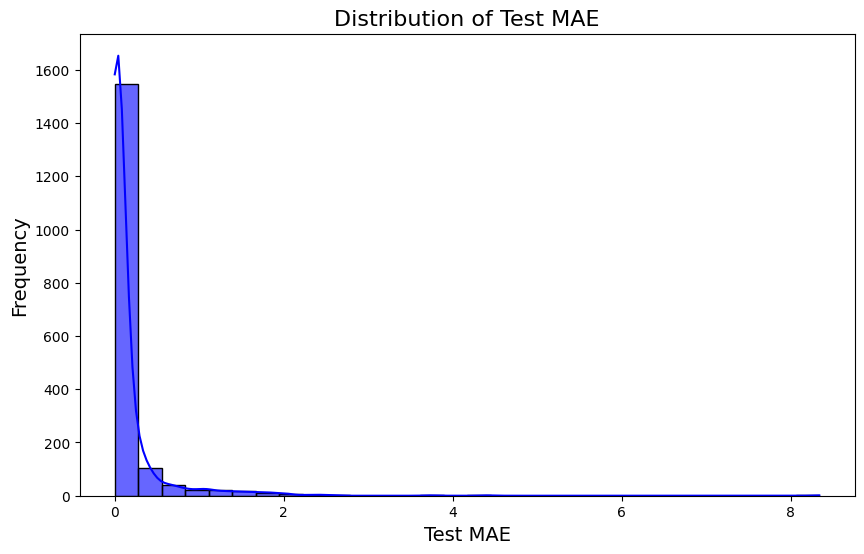

In [ ]:
test_maes = []

# Testing phase
with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr,
                    batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_maes.append(float(loss))  # Store individual MAE

# Calculate average test MAE
avg_test_loss = sum(test_maes) / len(test_maes)
print('Average Test MAE: {:.5f}'.format(avg_test_loss))

# Plotting the distribution of test MAEs
plt.figure(figsize=(10, 6))
sns.histplot(test_maes, bins=30, kde=True, color='blue', alpha=0.6)

# Adding titles and labels
plt.title('Distribution of Test MAE', fontsize=16)
plt.xlabel('Test MAE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show plot
plt.show()

In [ ]:
data

Data(x=[18, 41], y=0.2537768483161926, edge_index=[2, 38], edge_attr=[38, 10], graph_level_features=[8])

In [ ]:
from sklearn.metrics import r2_score

# Initialize variables to store actual and predicted values
all_actual = []
all_predicted = []

# Testing phase
with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr,
                    batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point

        # Convert actual and predicted values to numpy arrays
        actual_values = data.y.squeeze().cpu().numpy()  # Get actual values
        predicted_values = out.squeeze().cpu().numpy()  # Get predicted values

        # Ensure they are 1D arrays before extending
        if actual_values.ndim == 0:
            all_actual.append(actual_values)
        else:
            all_actual.extend(actual_values)  # Add to the list of actual values

        if predicted_values.ndim == 0:
            all_predicted.append(predicted_values)
        else:
            all_predicted.extend(predicted_values)  # Add to the list of predicted values

# Calculate R-squared
r2 = r2_score(all_actual, all_predicted)

print('R-squared: {:.5f}'.format(r2))


R-squared: 0.81578


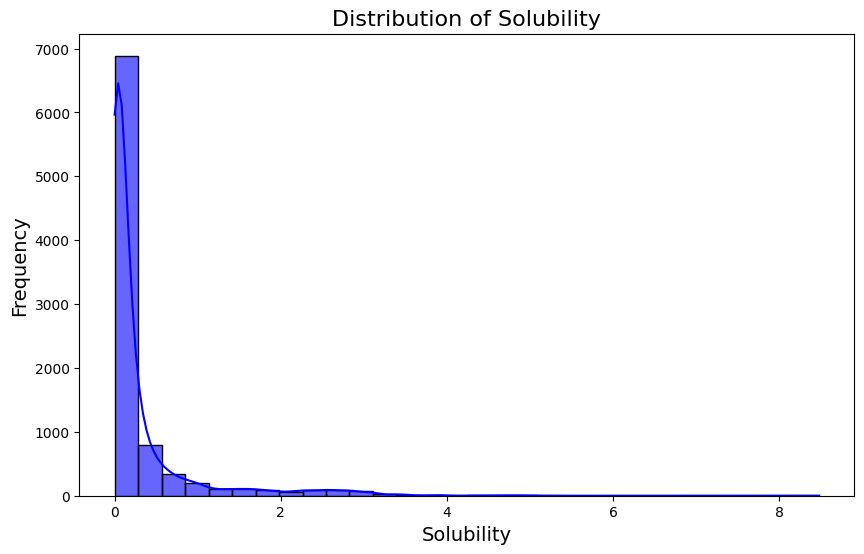

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame (replace this with your actual DataFrame)
# df = pd.read_csv('your_data.csv')  # Uncomment to load your data

# Ensure 'Solubility' column exists
if 'Solubility' in df.columns:
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 6))

    # Plotting histogram
    sns.histplot(df['Solubility'], bins=30, kde=True, color='blue', alpha=0.6)

    # Adding titles and labels
    plt.title('Distribution of Solubility', fontsize=16)
    plt.xlabel('Solubility', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Show plot
    plt.show()
else:
    print("The 'Solubility' column does not exist in the DataFrame.")


# weighted sum of different poolings

In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))




    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

#Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 5989/5989 [01:16<00:00, 78.38it/s]


Epoch: 001, Average MAE: 1.31239
Validation MAE: 1.02046
Model improved! Saving model...


100%|██████████| 5989/5989 [01:11<00:00, 83.36it/s]


Epoch: 002, Average MAE: 0.98725
Validation MAE: 0.95631
Model improved! Saving model...


100%|██████████| 5989/5989 [01:12<00:00, 82.98it/s]


Epoch: 003, Average MAE: 0.91413
Validation MAE: 0.83896
Model improved! Saving model...


100%|██████████| 5989/5989 [01:11<00:00, 83.19it/s]


Epoch: 004, Average MAE: 0.87272
Validation MAE: 0.80979
Model improved! Saving model...


100%|██████████| 5989/5989 [01:11<00:00, 83.32it/s]


Epoch: 005, Average MAE: 0.83824
Validation MAE: 0.82140
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.57it/s]


Epoch: 006, Average MAE: 0.83916
Validation MAE: 0.80681
Model improved! Saving model...


100%|██████████| 5989/5989 [01:11<00:00, 83.43it/s]


Epoch: 007, Average MAE: 0.81883
Validation MAE: 0.78469
Model improved! Saving model...


100%|██████████| 5989/5989 [01:11<00:00, 83.24it/s]


Epoch: 008, Average MAE: 0.79700
Validation MAE: 0.77336
Model improved! Saving model...


100%|██████████| 5989/5989 [01:11<00:00, 84.24it/s]


Epoch: 009, Average MAE: 0.78728
Validation MAE: 0.75780
Model improved! Saving model...


100%|██████████| 5989/5989 [01:12<00:00, 82.68it/s]


Epoch: 010, Average MAE: 0.77371
Validation MAE: 0.82509
No improvement.


100%|██████████| 5989/5989 [01:11<00:00, 83.32it/s]


Epoch: 011, Average MAE: 0.76237
Validation MAE: 0.75945
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.76it/s]


Epoch: 012, Average MAE: 0.75667
Validation MAE: 0.76002
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.80it/s]


Epoch: 013, Average MAE: 0.75087
Validation MAE: 0.76634
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.87it/s]


Epoch: 014, Average MAE: 0.75471
Validation MAE: 0.73713
Model improved! Saving model...


100%|██████████| 5989/5989 [01:11<00:00, 83.42it/s]


Epoch: 015, Average MAE: 0.73706
Validation MAE: 0.77995
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.48it/s]


Epoch: 016, Average MAE: 0.72620
Validation MAE: 0.73671
Model improved! Saving model...


100%|██████████| 5989/5989 [01:12<00:00, 82.66it/s]


Epoch: 017, Average MAE: 0.72641
Validation MAE: 0.72144
Model improved! Saving model...


100%|██████████| 5989/5989 [01:11<00:00, 83.68it/s]


Epoch: 018, Average MAE: 0.71529
Validation MAE: 0.72273
No improvement.


100%|██████████| 5989/5989 [01:11<00:00, 83.68it/s]


Epoch: 019, Average MAE: 0.71137
Validation MAE: 0.73650
No improvement.


100%|██████████| 5989/5989 [01:10<00:00, 84.45it/s]


Epoch: 020, Average MAE: 0.71171
Validation MAE: 0.72325
No improvement.
Test MAE: 0.75481


In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, device, train, val, and test are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr,
                    batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch + 1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr,
                        batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss

    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))  # Load the best model
model.eval()

# Testing phase
test_loss = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr,
                    batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)

avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


# replace GRU by LSTM

In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

#Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 5330/5330 [00:50<00:00, 105.85it/s]


Epoch: 001, Average MAE: 0.24282
Validation MAE: 0.20609
Model improved! Saving model...


100%|██████████| 5330/5330 [00:47<00:00, 111.21it/s]


Epoch: 002, Average MAE: 0.19877
Validation MAE: 0.20787
No improvement.


100%|██████████| 5330/5330 [00:47<00:00, 111.13it/s]


Epoch: 003, Average MAE: 0.18716
Validation MAE: 0.16446
Model improved! Saving model...


100%|██████████| 5330/5330 [00:47<00:00, 112.02it/s]


Epoch: 004, Average MAE: 0.17720
Validation MAE: 0.16408
Model improved! Saving model...


100%|██████████| 5330/5330 [00:47<00:00, 111.69it/s]


Epoch: 005, Average MAE: 0.17074
Validation MAE: 0.16529
No improvement.


100%|██████████| 5330/5330 [00:48<00:00, 109.51it/s]


Epoch: 006, Average MAE: 0.16594
Validation MAE: 0.15527
Model improved! Saving model...


100%|██████████| 5330/5330 [00:48<00:00, 110.50it/s]


Epoch: 007, Average MAE: 0.16032
Validation MAE: 0.16543
No improvement.


100%|██████████| 5330/5330 [00:47<00:00, 111.05it/s]


Epoch: 008, Average MAE: 0.16290
Validation MAE: 0.15848
No improvement.


100%|██████████| 5330/5330 [00:48<00:00, 109.75it/s]


Epoch: 009, Average MAE: 0.15765
Validation MAE: 0.14414
Model improved! Saving model...


100%|██████████| 5330/5330 [00:48<00:00, 109.43it/s]


Epoch: 010, Average MAE: 0.15617
Validation MAE: 0.14601
No improvement.


100%|██████████| 5330/5330 [00:48<00:00, 109.88it/s]


Epoch: 011, Average MAE: 0.15368
Validation MAE: 0.15369
No improvement.


100%|██████████| 5330/5330 [00:48<00:00, 108.94it/s]


Epoch: 012, Average MAE: 0.15062
Validation MAE: 0.15079
No improvement.


100%|██████████| 5330/5330 [00:48<00:00, 109.54it/s]


Epoch: 013, Average MAE: 0.14879
Validation MAE: 0.14390
Model improved! Saving model...


100%|██████████| 5330/5330 [00:48<00:00, 109.61it/s]


Epoch: 014, Average MAE: 0.14921
Validation MAE: 0.14348
Model improved! Saving model...


100%|██████████| 5330/5330 [00:50<00:00, 106.57it/s]


Epoch: 015, Average MAE: 0.14848
Validation MAE: 0.14540
No improvement.


100%|██████████| 5330/5330 [00:48<00:00, 109.41it/s]


Epoch: 016, Average MAE: 0.14576
Validation MAE: 0.14262
Model improved! Saving model...


100%|██████████| 5330/5330 [00:49<00:00, 107.74it/s]


Epoch: 017, Average MAE: 0.14394
Validation MAE: 0.13891
Model improved! Saving model...


100%|██████████| 5330/5330 [00:48<00:00, 109.88it/s]


Epoch: 018, Average MAE: 0.14479
Validation MAE: 0.14361
No improvement.


100%|██████████| 5330/5330 [00:48<00:00, 110.42it/s]


Epoch: 019, Average MAE: 0.14546
Validation MAE: 0.14060
No improvement.


100%|██████████| 5330/5330 [00:48<00:00, 110.19it/s]


Epoch: 020, Average MAE: 0.14293
Validation MAE: 0.15074
No improvement.
Test MAE: 0.15705


In [ ]:
avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

Test MAE: 0.76096


In [ ]:

avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

Test MAE: 0.76096


# multiple poolings

In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        # print('Model improved! Saving model...')
        # torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


 12%|█▏        | 737/5989 [00:08<00:58, 89.88it/s]


KeyboardInterrupt: 

# replace GAT by GATV2

In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

#Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 5989/5989 [01:15<00:00, 79.15it/s]


Epoch: 001, Average MAE: 1.30743
Validation MAE: 0.95414
Model improved! Saving model...


100%|██████████| 5989/5989 [01:12<00:00, 82.12it/s]


Epoch: 002, Average MAE: 0.98808
Validation MAE: 0.90719
Model improved! Saving model...


100%|██████████| 5989/5989 [01:12<00:00, 82.23it/s]


Epoch: 003, Average MAE: 0.91393
Validation MAE: 0.85536
Model improved! Saving model...


100%|██████████| 5989/5989 [01:12<00:00, 82.04it/s]


Epoch: 004, Average MAE: 0.86332
Validation MAE: 0.83110
Model improved! Saving model...


100%|██████████| 5989/5989 [01:12<00:00, 82.08it/s]


Epoch: 005, Average MAE: 0.83532
Validation MAE: 0.81206
Model improved! Saving model...


100%|██████████| 5989/5989 [01:13<00:00, 82.02it/s]


Epoch: 006, Average MAE: 0.82118
Validation MAE: 0.78237
Model improved! Saving model...


100%|██████████| 5989/5989 [01:13<00:00, 81.72it/s]


Epoch: 007, Average MAE: 0.81007
Validation MAE: 0.78358
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.78it/s]


Epoch: 008, Average MAE: 0.78995
Validation MAE: 0.81673
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.89it/s]


Epoch: 009, Average MAE: 0.78042
Validation MAE: 0.78190
Model improved! Saving model...


100%|██████████| 5989/5989 [01:12<00:00, 82.95it/s]


Epoch: 010, Average MAE: 0.77175
Validation MAE: 0.73447
Model improved! Saving model...


100%|██████████| 5989/5989 [01:13<00:00, 81.63it/s]


Epoch: 011, Average MAE: 0.75793
Validation MAE: 0.75470
No improvement.


100%|██████████| 5989/5989 [01:13<00:00, 81.94it/s]


Epoch: 012, Average MAE: 0.75689
Validation MAE: 0.80259
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.17it/s]


Epoch: 013, Average MAE: 0.74842
Validation MAE: 0.75329
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.06it/s]


Epoch: 014, Average MAE: 0.73727
Validation MAE: 0.73178
Model improved! Saving model...


100%|██████████| 5989/5989 [01:13<00:00, 81.94it/s]


Epoch: 015, Average MAE: 0.73908
Validation MAE: 0.75132
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.08it/s]


Epoch: 016, Average MAE: 0.73626
Validation MAE: 0.73670
No improvement.


100%|██████████| 5989/5989 [01:12<00:00, 82.56it/s]


Epoch: 017, Average MAE: 0.73489
Validation MAE: 0.73614
No improvement.


100%|██████████| 5989/5989 [01:13<00:00, 81.95it/s]


Epoch: 018, Average MAE: 0.72845
Validation MAE: 0.75793
No improvement.


100%|██████████| 5989/5989 [01:13<00:00, 81.90it/s]


Epoch: 019, Average MAE: 0.72045
Validation MAE: 0.73561
No improvement.


100%|██████████| 5989/5989 [01:13<00:00, 81.79it/s]


Epoch: 020, Average MAE: 0.72078
Validation MAE: 0.76851
No improvement.
Test MAE: 0.74857


In [ ]:
avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))

Test MAE: 0.83841


In [ ]:
# import torch
# import random
# from tqdm import tqdm
# import torch.nn as nn

# mae_loss = nn.L1Loss()

# def train():
#     total_loss = total_examples = 0
#     for data in train_loader:
#         data = data.to(device)
#         optimizer.zero_grad()
#         out = model(data.x, data.edge_index, data.edge_attr, data.batch)
#         loss = mae_loss(out, data.y)
#         loss.backward()
#         optimizer.step()
#         total_loss += float(loss) * data.num_graphs
#         total_examples += data.num_graphs
#     return total_loss / total_examples


# @torch.no_grad()
# def test(loader):
#     mae = []
#     for data in loader:
#         data = data.to(device)
#         out = model(data.x, data.edge_index, data.edge_attr, data.batch)
#         mae.append(mae_loss(out, data.y))
#     return np.mean(mae)


# for epoch in range(1, 51):
#     train_mae = train()
#     val_mae = test(val_loader)
#     test_mae = test(test_loader)
#     print(f'Epoch: {epoch:03d}, Loss: {train_mae:.4f}, Val: {val_mae:.4f}, Test: {test_mae:.4f}')


In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        # print('Model improved! Saving model...')
        # torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 5989/5989 [01:40<00:00, 59.35it/s]


Epoch: 001, Average MAE: 1.33047
Validation MAE: 1.03837


100%|██████████| 5989/5989 [01:34<00:00, 63.19it/s]


Epoch: 002, Average MAE: 1.00191
Validation MAE: 0.98594


100%|██████████| 5989/5989 [01:32<00:00, 65.05it/s]


Epoch: 003, Average MAE: 0.93028
Validation MAE: 1.02646


100%|██████████| 5989/5989 [01:34<00:00, 63.54it/s]


Epoch: 004, Average MAE: 0.90106
Validation MAE: 0.86467


100%|██████████| 5989/5989 [01:34<00:00, 63.70it/s]


Epoch: 005, Average MAE: 0.86737
Validation MAE: 0.84155


100%|██████████| 5989/5989 [01:33<00:00, 64.25it/s]


Epoch: 006, Average MAE: 0.84924
Validation MAE: 0.88438


100%|██████████| 5989/5989 [01:33<00:00, 63.73it/s]


Epoch: 007, Average MAE: 0.82948
Validation MAE: 0.82914


100%|██████████| 5989/5989 [01:34<00:00, 63.59it/s]


Epoch: 008, Average MAE: 0.81509
Validation MAE: 0.86049


100%|██████████| 5989/5989 [01:35<00:00, 62.87it/s]


Epoch: 009, Average MAE: 0.81255
Validation MAE: 0.84283


100%|██████████| 5989/5989 [01:32<00:00, 64.42it/s]


Epoch: 010, Average MAE: 0.78777
Validation MAE: 0.81964


100%|██████████| 5989/5989 [01:34<00:00, 63.32it/s]


Epoch: 011, Average MAE: 0.77745
Validation MAE: 0.79105


100%|██████████| 5989/5989 [01:34<00:00, 63.30it/s]


Epoch: 012, Average MAE: 0.77153
Validation MAE: 0.78184


100%|██████████| 5989/5989 [01:34<00:00, 63.25it/s]


Epoch: 013, Average MAE: 0.76048
Validation MAE: 0.82602


100%|██████████| 5989/5989 [01:36<00:00, 62.18it/s]


Epoch: 014, Average MAE: 0.75337
Validation MAE: 0.76877


100%|██████████| 5989/5989 [01:34<00:00, 63.46it/s]


Epoch: 015, Average MAE: 0.73713
Validation MAE: 0.78295


100%|██████████| 5989/5989 [01:36<00:00, 62.07it/s]


Epoch: 016, Average MAE: 0.74142
Validation MAE: 0.78203


100%|██████████| 5989/5989 [01:37<00:00, 61.27it/s]


Epoch: 017, Average MAE: 0.74088
Validation MAE: 0.78201


100%|██████████| 5989/5989 [01:35<00:00, 62.67it/s]


Epoch: 018, Average MAE: 0.72457
Validation MAE: 0.77885


100%|██████████| 5989/5989 [01:35<00:00, 62.74it/s]


Epoch: 019, Average MAE: 0.72008
Validation MAE: 0.74178


100%|██████████| 5989/5989 [01:34<00:00, 63.35it/s]


Epoch: 020, Average MAE: 0.72251
Validation MAE: 0.75062
Test MAE: 0.72363


# Add normalized graph features

In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        # print('Model improved! Saving model...')
        # torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 5989/5989 [01:18<00:00, 76.12it/s]


Epoch: 001, Average MAE: 1.32975
Validation MAE: 1.04954


100%|██████████| 5989/5989 [01:15<00:00, 79.04it/s]


Epoch: 002, Average MAE: 0.96190
Validation MAE: 0.94707


100%|██████████| 5989/5989 [01:16<00:00, 78.15it/s]


Epoch: 003, Average MAE: 0.88732
Validation MAE: 0.86532


100%|██████████| 5989/5989 [01:14<00:00, 80.74it/s]


Epoch: 004, Average MAE: 0.85776
Validation MAE: 0.87679


100%|██████████| 5989/5989 [01:14<00:00, 80.12it/s]


Epoch: 005, Average MAE: 0.82278
Validation MAE: 0.82325


100%|██████████| 5989/5989 [01:14<00:00, 79.91it/s]


Epoch: 006, Average MAE: 0.79960
Validation MAE: 0.90287


100%|██████████| 5989/5989 [01:12<00:00, 82.10it/s]


Epoch: 007, Average MAE: 0.78255
Validation MAE: 0.81266


100%|██████████| 5989/5989 [01:14<00:00, 80.86it/s]


Epoch: 008, Average MAE: 0.76975
Validation MAE: 0.78530


100%|██████████| 5989/5989 [01:12<00:00, 82.42it/s]


Epoch: 009, Average MAE: 0.74663
Validation MAE: 0.79944


100%|██████████| 5989/5989 [01:12<00:00, 83.06it/s]


Epoch: 010, Average MAE: 0.75664
Validation MAE: 0.81205


100%|██████████| 5989/5989 [01:11<00:00, 83.43it/s]


Epoch: 011, Average MAE: 0.73795
Validation MAE: 0.76219


100%|██████████| 5989/5989 [01:16<00:00, 78.66it/s]


Epoch: 012, Average MAE: 0.72737
Validation MAE: 0.79058


100%|██████████| 5989/5989 [01:13<00:00, 81.99it/s]


Epoch: 013, Average MAE: 0.72177
Validation MAE: 0.77815


100%|██████████| 5989/5989 [01:12<00:00, 82.70it/s]


Epoch: 014, Average MAE: 0.71702
Validation MAE: 0.74936


100%|██████████| 5989/5989 [01:13<00:00, 81.28it/s]


Epoch: 015, Average MAE: 0.70131
Validation MAE: 0.79085


100%|██████████| 5989/5989 [01:13<00:00, 81.12it/s]


Epoch: 016, Average MAE: 0.69937
Validation MAE: 0.77515


100%|██████████| 5989/5989 [01:11<00:00, 83.27it/s]


Epoch: 017, Average MAE: 0.69920
Validation MAE: 0.76853


100%|██████████| 5989/5989 [01:12<00:00, 82.68it/s]


Epoch: 018, Average MAE: 0.69029
Validation MAE: 0.77776


100%|██████████| 5989/5989 [01:12<00:00, 82.42it/s]


Epoch: 019, Average MAE: 0.68976
Validation MAE: 0.77661
Early stopping triggered.
Test MAE: 0.79213


# Improve one ? Add graph level features and attention of graph level embeddings + features

In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        # print('Model improved! Saving model...')
        # torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


100%|██████████| 5330/5330 [01:04<00:00, 82.43it/s]


Epoch: 001, Average MAE: 0.23530
Validation MAE: 0.18925


100%|██████████| 5330/5330 [01:00<00:00, 88.53it/s]


Epoch: 002, Average MAE: 0.19493
Validation MAE: 0.17101


100%|██████████| 5330/5330 [00:59<00:00, 89.73it/s]


Epoch: 003, Average MAE: 0.18191
Validation MAE: 0.16147


100%|██████████| 5330/5330 [01:00<00:00, 88.47it/s]


Epoch: 004, Average MAE: 0.16879
Validation MAE: 0.16277


100%|██████████| 5330/5330 [00:59<00:00, 89.71it/s]


Epoch: 005, Average MAE: 0.16449
Validation MAE: 0.15116


100%|██████████| 5330/5330 [01:00<00:00, 88.62it/s]


Epoch: 006, Average MAE: 0.15918
Validation MAE: 0.15490


100%|██████████| 5330/5330 [00:59<00:00, 88.97it/s]


Epoch: 007, Average MAE: 0.15701
Validation MAE: 0.14625


100%|██████████| 5330/5330 [00:59<00:00, 89.38it/s]


Epoch: 008, Average MAE: 0.15042
Validation MAE: 0.14149


100%|██████████| 5330/5330 [00:59<00:00, 89.31it/s] 


Epoch: 009, Average MAE: 0.15004
Validation MAE: 0.17217


100%|██████████| 5330/5330 [01:00<00:00, 88.70it/s]


Epoch: 010, Average MAE: 0.14914
Validation MAE: 0.14210


100%|██████████| 5330/5330 [01:00<00:00, 88.73it/s]


Epoch: 011, Average MAE: 0.14464
Validation MAE: 0.13938


100%|██████████| 5330/5330 [01:00<00:00, 87.74it/s]


Epoch: 012, Average MAE: 0.14689
Validation MAE: 0.14886


100%|██████████| 5330/5330 [01:00<00:00, 87.55it/s]


Epoch: 013, Average MAE: 0.14200
Validation MAE: 0.13911


100%|██████████| 5330/5330 [01:00<00:00, 88.61it/s]


Epoch: 014, Average MAE: 0.14397
Validation MAE: 0.14727


100%|██████████| 5330/5330 [01:00<00:00, 87.83it/s]


Epoch: 015, Average MAE: 0.14454
Validation MAE: 0.13729


100%|██████████| 5330/5330 [00:59<00:00, 89.06it/s]


Epoch: 016, Average MAE: 0.14148
Validation MAE: 0.13902


100%|██████████| 5330/5330 [01:00<00:00, 87.64it/s]


Epoch: 017, Average MAE: 0.14105
Validation MAE: 0.14078


100%|██████████| 5330/5330 [01:00<00:00, 87.42it/s]


Epoch: 018, Average MAE: 0.14102
Validation MAE: 0.14815


100%|██████████| 5330/5330 [01:01<00:00, 86.79it/s]


Epoch: 019, Average MAE: 0.13903
Validation MAE: 0.13564


100%|██████████| 5330/5330 [01:00<00:00, 87.42it/s]


Epoch: 020, Average MAE: 0.13952
Validation MAE: 0.14658
Test MAE: 0.16319


# replace GRU by LSTM

In [ ]:
import torch
import random
from tqdm import tqdm
import torch.nn as nn

mae_loss = nn.L1Loss()

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
trigger_times = 0
torch.autograd.set_detect_anomaly(True)

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        loss = mae_loss(out.squeeze(), data.y.squeeze())
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average MAE: {:.5f}'.format(epoch+1, avg_loss))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = mae_loss(out.squeeze(), data.y.squeeze())
            val_loss += float(loss)  # Aggregate validation loss


    avg_val_loss = val_loss / len(val)
    print('Validation MAE: {:.5f}'.format(avg_val_loss))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        # print('Model improved! Saving model...')
        # torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        # print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
# model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = mae_loss(out.squeeze(), data.y.squeeze())
        test_loss += float(loss)


avg_test_loss = test_loss / len(test)
print('Test MAE: {:.5f}'.format(avg_test_loss))


  1%|          | 61/5989 [00:07<11:52,  8.32it/s]


KeyboardInterrupt: 

In [ ]:
data

NameError: name 'data' is not defined

In [ ]:
batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device)
batch.shape

torch.Size([17])

In [ ]:
row = torch.arange(batch.size(0), device=batch.device)
row = row + 1
edge_index = torch.stack([row, batch], dim=0)
out = global_add_pool(data.x, batch).relu_()


In [ ]:
row

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
edge_index

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))


100%|██████████| 5989/5989 [01:30<00:00, 66.27it/s]


Epoch: 000, Average loss: 0.84067, Accuracy: 0.61079
Validation Loss: 0.74503, Validation Accuracy: 0.65631
Model improved! Saving model...


100%|██████████| 5989/5989 [01:25<00:00, 70.39it/s]


Epoch: 001, Average loss: 0.67747, Accuracy: 0.70229
Validation Loss: 0.60048, Validation Accuracy: 0.75251
Model improved! Saving model...


100%|██████████| 5989/5989 [01:24<00:00, 70.47it/s]


Epoch: 002, Average loss: 0.62435, Accuracy: 0.73602
Validation Loss: 0.63153, Validation Accuracy: 0.70691
No improvement.


100%|██████████| 5989/5989 [01:28<00:00, 67.44it/s]


Epoch: 003, Average loss: 0.60624, Accuracy: 0.73852
Validation Loss: 0.57875, Validation Accuracy: 0.75251
Model improved! Saving model...


100%|██████████| 5989/5989 [01:29<00:00, 66.78it/s]


Epoch: 004, Average loss: 0.58222, Accuracy: 0.74503
Validation Loss: 0.66645, Validation Accuracy: 0.70792
No improvement.


100%|██████████| 5989/5989 [01:29<00:00, 67.01it/s]


Epoch: 005, Average loss: 0.57177, Accuracy: 0.75372
Validation Loss: 0.57617, Validation Accuracy: 0.75301
Model improved! Saving model...


100%|██████████| 5989/5989 [01:28<00:00, 67.53it/s]


Epoch: 006, Average loss: 0.55791, Accuracy: 0.76156
Validation Loss: 0.54782, Validation Accuracy: 0.75651
Model improved! Saving model...


100%|██████████| 5989/5989 [01:27<00:00, 68.82it/s]


Epoch: 007, Average loss: 0.55442, Accuracy: 0.76958
Validation Loss: 0.59337, Validation Accuracy: 0.73798
No improvement.


100%|██████████| 5989/5989 [01:27<00:00, 68.74it/s]


Epoch: 008, Average loss: 0.54697, Accuracy: 0.77175
Validation Loss: 0.53553, Validation Accuracy: 0.77004
Model improved! Saving model...


100%|██████████| 5989/5989 [01:25<00:00, 69.82it/s]


Epoch: 009, Average loss: 0.54194, Accuracy: 0.77041
Validation Loss: 0.54816, Validation Accuracy: 0.76954
No improvement.


100%|██████████| 5989/5989 [01:26<00:00, 68.94it/s]


Epoch: 010, Average loss: 0.52991, Accuracy: 0.77793
Validation Loss: 0.58019, Validation Accuracy: 0.74800
No improvement.


100%|██████████| 5989/5989 [01:27<00:00, 68.53it/s]


Epoch: 011, Average loss: 0.52923, Accuracy: 0.77826
Validation Loss: 0.53798, Validation Accuracy: 0.77806
No improvement.


100%|██████████| 5989/5989 [01:32<00:00, 64.98it/s]


Epoch: 012, Average loss: 0.52822, Accuracy: 0.77576
Validation Loss: 0.55990, Validation Accuracy: 0.76002
No improvement.


100%|██████████| 5989/5989 [01:27<00:00, 68.26it/s]


Epoch: 013, Average loss: 0.51517, Accuracy: 0.78294
Validation Loss: 0.54737, Validation Accuracy: 0.75952
No improvement.


100%|██████████| 5989/5989 [01:30<00:00, 66.39it/s]


Epoch: 014, Average loss: 0.51236, Accuracy: 0.78694
Validation Loss: 0.54886, Validation Accuracy: 0.76904
No improvement.


100%|██████████| 5989/5989 [01:28<00:00, 67.93it/s]


Epoch: 015, Average loss: 0.51066, Accuracy: 0.78711
Validation Loss: 0.54999, Validation Accuracy: 0.77655
No improvement.


100%|██████████| 5989/5989 [01:27<00:00, 68.31it/s]


Epoch: 016, Average loss: 0.50498, Accuracy: 0.78845
Validation Loss: 0.54452, Validation Accuracy: 0.76503
No improvement.


100%|██████████| 5989/5989 [01:30<00:00, 66.32it/s]


Epoch: 017, Average loss: 0.50632, Accuracy: 0.79229
Validation Loss: 0.53458, Validation Accuracy: 0.77956
Model improved! Saving model...


100%|██████████| 5989/5989 [01:29<00:00, 67.12it/s]


Epoch: 018, Average loss: 0.51131, Accuracy: 0.78811
Validation Loss: 0.53543, Validation Accuracy: 0.76904
No improvement.


100%|██████████| 5989/5989 [01:29<00:00, 66.55it/s]


Epoch: 019, Average loss: 0.49650, Accuracy: 0.79462
Validation Loss: 0.53249, Validation Accuracy: 0.77455
Model improved! Saving model...
Test Loss: 0.52933, Test Accuracy: 0.78518


In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))


100%|██████████| 5989/5989 [01:11<00:00, 83.70it/s]


Epoch: 000, Average loss: 0.83369, Accuracy: 0.60912
Validation Loss: 0.68230, Validation Accuracy: 0.68938
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.52it/s]


Epoch: 001, Average loss: 0.64718, Accuracy: 0.71615
Validation Loss: 0.66050, Validation Accuracy: 0.70792
Model improved! Saving model...


100%|██████████| 5989/5989 [01:08<00:00, 87.31it/s]


Epoch: 002, Average loss: 0.61375, Accuracy: 0.72817
Validation Loss: 0.60527, Validation Accuracy: 0.73998
Model improved! Saving model...


100%|██████████| 5989/5989 [01:08<00:00, 87.89it/s]


Epoch: 003, Average loss: 0.59618, Accuracy: 0.74470
Validation Loss: 0.60248, Validation Accuracy: 0.76804
Model improved! Saving model...


100%|██████████| 5989/5989 [01:08<00:00, 87.33it/s]


Epoch: 004, Average loss: 0.57850, Accuracy: 0.75071
Validation Loss: 0.59701, Validation Accuracy: 0.74499
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.08it/s]


Epoch: 005, Average loss: 0.56510, Accuracy: 0.76106
Validation Loss: 0.57736, Validation Accuracy: 0.77004
Model improved! Saving model...


100%|██████████| 5989/5989 [01:08<00:00, 88.00it/s]


Epoch: 006, Average loss: 0.55220, Accuracy: 0.76440
Validation Loss: 0.60304, Validation Accuracy: 0.75701
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.44it/s]


Epoch: 007, Average loss: 0.54679, Accuracy: 0.76574
Validation Loss: 0.55266, Validation Accuracy: 0.76653
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.28it/s]


Epoch: 008, Average loss: 0.55262, Accuracy: 0.76173
Validation Loss: 0.55538, Validation Accuracy: 0.76152
No improvement.


100%|██████████| 5989/5989 [01:07<00:00, 88.23it/s]


Epoch: 009, Average loss: 0.54612, Accuracy: 0.76474
Validation Loss: 0.56096, Validation Accuracy: 0.76854
No improvement.


100%|██████████| 5989/5989 [01:09<00:00, 86.67it/s]


Epoch: 010, Average loss: 0.53367, Accuracy: 0.77258
Validation Loss: 0.56249, Validation Accuracy: 0.77555
No improvement.


100%|██████████| 5989/5989 [01:09<00:00, 86.24it/s]


Epoch: 011, Average loss: 0.52918, Accuracy: 0.77592
Validation Loss: 0.55742, Validation Accuracy: 0.77104
No improvement.


100%|██████████| 5989/5989 [01:09<00:00, 86.57it/s]


Epoch: 012, Average loss: 0.52491, Accuracy: 0.77242
Validation Loss: 0.54159, Validation Accuracy: 0.77655
Model improved! Saving model...


100%|██████████| 5989/5989 [01:08<00:00, 87.36it/s]


Epoch: 013, Average loss: 0.52571, Accuracy: 0.77809
Validation Loss: 0.57228, Validation Accuracy: 0.75852
No improvement.


100%|██████████| 5989/5989 [01:09<00:00, 86.43it/s]


Epoch: 014, Average loss: 0.51773, Accuracy: 0.77793
Validation Loss: 0.56135, Validation Accuracy: 0.76804
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.49it/s]


Epoch: 015, Average loss: 0.51061, Accuracy: 0.79262
Validation Loss: 0.54066, Validation Accuracy: 0.77605
Model improved! Saving model...


100%|██████████| 5989/5989 [01:08<00:00, 87.31it/s]


Epoch: 016, Average loss: 0.51414, Accuracy: 0.78594
Validation Loss: 0.57913, Validation Accuracy: 0.75651
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.29it/s]


Epoch: 017, Average loss: 0.50813, Accuracy: 0.78477
Validation Loss: 0.54794, Validation Accuracy: 0.77355
No improvement.


100%|██████████| 5989/5989 [01:09<00:00, 86.73it/s]


Epoch: 018, Average loss: 0.50427, Accuracy: 0.78878
Validation Loss: 0.54408, Validation Accuracy: 0.77054
No improvement.


100%|██████████| 5989/5989 [01:09<00:00, 86.77it/s]


Epoch: 019, Average loss: 0.49699, Accuracy: 0.78895
Validation Loss: 0.53856, Validation Accuracy: 0.78106
Model improved! Saving model...
Test Loss: 0.56196, Test Accuracy: 0.77316


In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
CUDA_LAUNCH_BLOCKING=1
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))


100%|██████████| 5989/5989 [01:26<00:00, 69.54it/s]


Epoch: 000, Average loss: 0.85077, Accuracy: 0.61379
Validation Loss: 0.68999, Validation Accuracy: 0.70090
Model improved! Saving model...


100%|██████████| 5989/5989 [01:20<00:00, 74.35it/s]


Epoch: 001, Average loss: 0.67507, Accuracy: 0.71147
Validation Loss: 0.74277, Validation Accuracy: 0.68186
No improvement.


100%|██████████| 5989/5989 [01:19<00:00, 75.06it/s]


Epoch: 002, Average loss: 0.62121, Accuracy: 0.73201
Validation Loss: 0.58771, Validation Accuracy: 0.75351
Model improved! Saving model...


100%|██████████| 5989/5989 [01:21<00:00, 73.63it/s]


Epoch: 003, Average loss: 0.59840, Accuracy: 0.74487
Validation Loss: 0.57700, Validation Accuracy: 0.75802
Model improved! Saving model...


100%|██████████| 5989/5989 [01:19<00:00, 75.68it/s]


Epoch: 004, Average loss: 0.57462, Accuracy: 0.75689
Validation Loss: 0.59203, Validation Accuracy: 0.75451
No improvement.


100%|██████████| 5989/5989 [01:21<00:00, 73.33it/s]


Epoch: 005, Average loss: 0.57065, Accuracy: 0.75739
Validation Loss: 0.55757, Validation Accuracy: 0.76353
Model improved! Saving model...


100%|██████████| 5989/5989 [01:19<00:00, 75.34it/s]


Epoch: 006, Average loss: 0.56141, Accuracy: 0.76724
Validation Loss: 0.60380, Validation Accuracy: 0.72745
No improvement.


100%|██████████| 5989/5989 [01:21<00:00, 73.60it/s]


Epoch: 007, Average loss: 0.55616, Accuracy: 0.76691
Validation Loss: 0.56383, Validation Accuracy: 0.75752
No improvement.


100%|██████████| 5989/5989 [01:20<00:00, 74.37it/s]


Epoch: 008, Average loss: 0.54910, Accuracy: 0.76674
Validation Loss: 0.57712, Validation Accuracy: 0.76052
No improvement.


100%|██████████| 5989/5989 [01:19<00:00, 75.11it/s]


Epoch: 009, Average loss: 0.53870, Accuracy: 0.77609
Validation Loss: 0.59208, Validation Accuracy: 0.73297
No improvement.


100%|██████████| 5989/5989 [01:23<00:00, 72.15it/s]


Epoch: 010, Average loss: 0.54117, Accuracy: 0.77208
Validation Loss: 0.56655, Validation Accuracy: 0.76202
No improvement.


100%|██████████| 5989/5989 [01:23<00:00, 72.00it/s]


Epoch: 011, Average loss: 0.53967, Accuracy: 0.77409
Validation Loss: 0.54259, Validation Accuracy: 0.77705
Model improved! Saving model...


100%|██████████| 5989/5989 [01:22<00:00, 72.85it/s]


Epoch: 012, Average loss: 0.53608, Accuracy: 0.76707
Validation Loss: 0.54477, Validation Accuracy: 0.76954
No improvement.


100%|██████████| 5989/5989 [01:21<00:00, 73.81it/s]


Epoch: 013, Average loss: 0.52757, Accuracy: 0.77425
Validation Loss: 0.54618, Validation Accuracy: 0.77104
No improvement.


100%|██████████| 5989/5989 [01:20<00:00, 74.28it/s]


Epoch: 014, Average loss: 0.52578, Accuracy: 0.77826
Validation Loss: 0.55329, Validation Accuracy: 0.77505
No improvement.


100%|██████████| 5989/5989 [01:25<00:00, 69.88it/s]


Epoch: 015, Average loss: 0.51995, Accuracy: 0.78477
Validation Loss: 0.56865, Validation Accuracy: 0.76754
No improvement.


100%|██████████| 5989/5989 [01:22<00:00, 72.56it/s]


Epoch: 016, Average loss: 0.51970, Accuracy: 0.78193
Validation Loss: 0.55099, Validation Accuracy: 0.76603
No improvement.


100%|██████████| 5989/5989 [01:22<00:00, 72.75it/s]


Epoch: 017, Average loss: 0.51853, Accuracy: 0.78694
Validation Loss: 0.57027, Validation Accuracy: 0.75852
No improvement.


100%|██████████| 5989/5989 [01:24<00:00, 71.19it/s]


Epoch: 018, Average loss: 0.51247, Accuracy: 0.78060
Validation Loss: 0.55355, Validation Accuracy: 0.77104
No improvement.


100%|██████████| 5989/5989 [01:22<00:00, 72.39it/s]


Epoch: 019, Average loss: 0.51177, Accuracy: 0.78527
Validation Loss: 0.53661, Validation Accuracy: 0.77906
Model improved! Saving model...
Test Loss: 0.50733, Test Accuracy: 0.80120


In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
CUDA_LAUNCH_BLOCKING=1
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))


100%|██████████| 5989/5989 [01:11<00:00, 84.16it/s]


Epoch: 000, Average loss: 0.85436, Accuracy: 0.60778
Validation Loss: 0.74178, Validation Accuracy: 0.65681
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 89.11it/s]


Epoch: 001, Average loss: 0.64916, Accuracy: 0.71548
Validation Loss: 0.73019, Validation Accuracy: 0.67134
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.88it/s]


Epoch: 002, Average loss: 0.60810, Accuracy: 0.73668
Validation Loss: 0.64961, Validation Accuracy: 0.72094
Model improved! Saving model...


100%|██████████| 5989/5989 [01:06<00:00, 89.82it/s]


Epoch: 003, Average loss: 0.58794, Accuracy: 0.74720
Validation Loss: 0.63767, Validation Accuracy: 0.72846
Model improved! Saving model...


100%|██████████| 5989/5989 [01:06<00:00, 89.87it/s]


Epoch: 004, Average loss: 0.56584, Accuracy: 0.76340
Validation Loss: 0.65949, Validation Accuracy: 0.70942
No improvement.


100%|██████████| 5989/5989 [01:05<00:00, 90.81it/s]


Epoch: 005, Average loss: 0.55449, Accuracy: 0.76056
Validation Loss: 0.60995, Validation Accuracy: 0.73747
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.75it/s]


Epoch: 006, Average loss: 0.55171, Accuracy: 0.76089
Validation Loss: 0.61828, Validation Accuracy: 0.74198
No improvement.


100%|██████████| 5989/5989 [01:07<00:00, 89.02it/s]


Epoch: 007, Average loss: 0.53734, Accuracy: 0.77225
Validation Loss: 0.61481, Validation Accuracy: 0.73597
No improvement.


100%|██████████| 5989/5989 [01:06<00:00, 89.81it/s]


Epoch: 008, Average loss: 0.52516, Accuracy: 0.77926
Validation Loss: 0.57212, Validation Accuracy: 0.76303
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.75it/s]


Epoch: 009, Average loss: 0.51602, Accuracy: 0.78143
Validation Loss: 0.59689, Validation Accuracy: 0.75301
No improvement.


100%|██████████| 5989/5989 [01:07<00:00, 88.17it/s]


Epoch: 010, Average loss: 0.51498, Accuracy: 0.78160
Validation Loss: 0.59276, Validation Accuracy: 0.75852
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.89it/s]


Epoch: 011, Average loss: 0.52642, Accuracy: 0.77793
Validation Loss: 0.60376, Validation Accuracy: 0.76904
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.92it/s]


Epoch: 012, Average loss: 0.51168, Accuracy: 0.78728
Validation Loss: 0.56862, Validation Accuracy: 0.76453
Model improved! Saving model...


100%|██████████| 5989/5989 [01:08<00:00, 88.05it/s]


Epoch: 013, Average loss: 0.50189, Accuracy: 0.78310
Validation Loss: 0.61160, Validation Accuracy: 0.75200
No improvement.


100%|██████████| 5989/5989 [01:07<00:00, 88.19it/s]


Epoch: 014, Average loss: 0.49787, Accuracy: 0.79496
Validation Loss: 0.60499, Validation Accuracy: 0.76653
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 88.05it/s]


Epoch: 015, Average loss: 0.49510, Accuracy: 0.79245
Validation Loss: 0.57490, Validation Accuracy: 0.76854
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.95it/s]


Epoch: 016, Average loss: 0.49007, Accuracy: 0.79279
Validation Loss: 0.57761, Validation Accuracy: 0.75852
No improvement.


100%|██████████| 5989/5989 [01:07<00:00, 88.39it/s]


Epoch: 017, Average loss: 0.48619, Accuracy: 0.79563
Validation Loss: 0.56819, Validation Accuracy: 0.77204
Model improved! Saving model...


100%|██████████| 5989/5989 [01:07<00:00, 88.45it/s]


Epoch: 018, Average loss: 0.48783, Accuracy: 0.79663
Validation Loss: 0.57474, Validation Accuracy: 0.75100
No improvement.


100%|██████████| 5989/5989 [01:08<00:00, 87.40it/s]


Epoch: 019, Average loss: 0.47551, Accuracy: 0.79846
Validation Loss: 0.59259, Validation Accuracy: 0.76102
No improvement.
Test Loss: 0.53733, Test Accuracy: 0.78117


In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming model, optimizer, CSE, device, train, and val are defined elsewhere
CUDA_LAUNCH_BLOCKING=1
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 20  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')
        torch.save(model.state_dict(), 'gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement

# Load the best model for testing
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.graph_level_features, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))


100%|██████████| 5989/5989 [01:19<00:00, 74.93it/s]


Epoch: 000, Average loss: 0.82706, Accuracy: 0.62765
Validation Loss: 0.77245, Validation Accuracy: 0.66283
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 77.79it/s]


Epoch: 001, Average loss: 0.64119, Accuracy: 0.72366
Validation Loss: 0.64681, Validation Accuracy: 0.72545
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 78.60it/s]


Epoch: 002, Average loss: 0.60780, Accuracy: 0.74086
Validation Loss: 0.59995, Validation Accuracy: 0.75000
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 78.68it/s]


Epoch: 003, Average loss: 0.57781, Accuracy: 0.75405
Validation Loss: 0.65299, Validation Accuracy: 0.71894
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.08it/s]


Epoch: 004, Average loss: 0.56418, Accuracy: 0.75906
Validation Loss: 0.61743, Validation Accuracy: 0.72695
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.76it/s]


Epoch: 005, Average loss: 0.55040, Accuracy: 0.76824
Validation Loss: 0.58008, Validation Accuracy: 0.75000
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 78.69it/s]


Epoch: 006, Average loss: 0.53890, Accuracy: 0.77642
Validation Loss: 0.57799, Validation Accuracy: 0.75651
Model improved! Saving model...


100%|██████████| 5989/5989 [01:15<00:00, 78.94it/s]


Epoch: 007, Average loss: 0.53069, Accuracy: 0.78210
Validation Loss: 0.57792, Validation Accuracy: 0.76754
Model improved! Saving model...


100%|██████████| 5989/5989 [01:17<00:00, 77.56it/s]


Epoch: 008, Average loss: 0.52230, Accuracy: 0.78761
Validation Loss: 0.55527, Validation Accuracy: 0.76804
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 78.62it/s]


Epoch: 009, Average loss: 0.51634, Accuracy: 0.78210
Validation Loss: 0.59114, Validation Accuracy: 0.75701
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.10it/s]


Epoch: 010, Average loss: 0.50713, Accuracy: 0.78327
Validation Loss: 0.58000, Validation Accuracy: 0.75802
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.26it/s]


Epoch: 011, Average loss: 0.50051, Accuracy: 0.79162
Validation Loss: 0.57951, Validation Accuracy: 0.76503
No improvement.


100%|██████████| 5989/5989 [01:17<00:00, 77.71it/s]


Epoch: 012, Average loss: 0.49515, Accuracy: 0.79279
Validation Loss: 0.57201, Validation Accuracy: 0.77154
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.05it/s]


Epoch: 013, Average loss: 0.49333, Accuracy: 0.79262
Validation Loss: 0.55736, Validation Accuracy: 0.77455
No improvement.


100%|██████████| 5989/5989 [01:18<00:00, 76.75it/s]


Epoch: 014, Average loss: 0.49008, Accuracy: 0.79663
Validation Loss: 0.56211, Validation Accuracy: 0.76202
No improvement.


100%|██████████| 5989/5989 [01:17<00:00, 77.06it/s]


Epoch: 015, Average loss: 0.48785, Accuracy: 0.79679
Validation Loss: 0.55073, Validation Accuracy: 0.76804
Model improved! Saving model...


100%|██████████| 5989/5989 [01:18<00:00, 76.13it/s]


Epoch: 016, Average loss: 0.48828, Accuracy: 0.79279
Validation Loss: 0.56119, Validation Accuracy: 0.76603
No improvement.


100%|██████████| 5989/5989 [01:18<00:00, 76.55it/s]


Epoch: 017, Average loss: 0.47811, Accuracy: 0.80681
Validation Loss: 0.57704, Validation Accuracy: 0.76754
No improvement.


100%|██████████| 5989/5989 [01:16<00:00, 78.10it/s]


Epoch: 018, Average loss: 0.48195, Accuracy: 0.79813
Validation Loss: 0.54990, Validation Accuracy: 0.77856
Model improved! Saving model...


100%|██████████| 5989/5989 [01:16<00:00, 78.71it/s]


Epoch: 019, Average loss: 0.47356, Accuracy: 0.80314
Validation Loss: 0.55569, Validation Accuracy: 0.77655
No improvement.
Test Loss: 0.53218, Test Accuracy: 0.77967


In [ ]:
out.shape

torch.Size([1, 3])

In [ ]:
model.load_state_dict(torch.load('gdrive/My Drive/Base_GNN_Solubility/New_architecture_best_model.pth',  weights_only=True))
model.eval()

# Testing phase
test_loss = 0
test_correct = 0

with torch.no_grad():
    for d in test:
        data = d.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, batch=torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate test point
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))
        test_loss += float(loss)

        if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
            test_correct += 1

avg_test_loss = test_loss / len(test)
print('Test Loss: {:.5f}, Test Accuracy: {:.5f}'.format(avg_test_loss, test_correct / len(test)))

RuntimeError: Error(s) in loading state_dict for AttentiveFP:
	Missing key(s) in state_dict: "atom_convs.0.att", "atom_convs.0.lin_l.weight", "atom_convs.0.lin_l.bias", "atom_convs.0.lin_r.weight", "atom_convs.0.lin_r.bias", "atom_convs.1.att", "atom_convs.1.lin_l.weight", "atom_convs.1.lin_l.bias", "atom_convs.1.lin_r.weight", "atom_convs.1.lin_r.bias", "mol_conv.att", "mol_conv.lin_l.weight", "mol_conv.lin_l.bias", "mol_conv.lin_r.weight", "mol_conv.lin_r.bias". 
	Unexpected key(s) in state_dict: "atom_convs.0.att_src", "atom_convs.0.att_dst", "atom_convs.0.lin.weight", "atom_convs.1.att_src", "atom_convs.1.att_dst", "atom_convs.1.lin.weight", "mol_conv.att_src", "mol_conv.att_dst", "mol_conv.lin.weight". 
	size mismatch for atom_convs.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for atom_convs.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for mol_conv.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).

# AttentiveFP with Edge Features Training and with explicit H

In [ ]:
# Training model
model.train()  # Set model to training mode
best_val_loss = float('inf')
patience = 10  # Number of epochs to wait for improvement
trigger_times = 0

for epoch in range(20):  # Run for a defined number of epochs
    sum_loss = 0  # Used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train)  # Shuffle the training data each epoch

    # Training loop
    for d in tqdm(train):  # Go over each training point
        data = d.to(device)  # Send data to device
        optimizer.zero_grad()  # Zero gradients
        out = model(data.x, data.edge_index, data.edge_attr, batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point

        # Calculate accuracy
        if torch.argmax(out) == torch.argmax(data.y):
            num_correct += 1

        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute loss
        sum_loss += float(loss)  # Aggregate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Average loss and accuracy for the training set
    avg_loss = sum_loss / len(train)
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, avg_loss, num_correct / len(train)))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in val:
            data = d.to(device)  # Send data to device
            out = model(data.x, data.edge_index,  data.edge_attr, batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))  # Evaluate data point
            loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y), [1]))  # Compute validation loss
            val_loss += float(loss)  # Aggregate validation loss

            if torch.argmax(out) == torch.argmax(data.y):  # Calculate accuracy
                val_correct += 1

    avg_val_loss = val_loss / len(val)
    print('Validation Loss: {:.5f}, Validation Accuracy: {:.5f}'.format(avg_val_loss, val_correct / len(val)))

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0  # Reset trigger times
        print('Model improved! Saving model...')  # Optionally save the model here
        # torch.save(model.state_dict(), 'best_model.pth')  # Save the model
    else:
        trigger_times += 1
        print('No improvement.')

    if trigger_times >= patience:
        print('Early stopping triggered.')
        break  # Stop training if no improvement


In [ ]:
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    data = t.to(device)
    out =  model(data.x, data.edge_index, data.edge_attr, batch = torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device))
    if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(10): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(10): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(10): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

In [ ]:
#train model
model.train() #set model to training mode
for epoch in range(10): #run for epochs of training
    sum_loss = 0 #used to compute average loss in an epoch
    num_correct = 0
    random.shuffle(train) #shuffle the training data each epoch
    for d in tqdm(train): #go over each training point
        data = d.to(device) #send data to device
        optimizer.zero_grad() #zero gradients
        out = model(data) #evaluate data point
        if torch.argmax(out) == torch.argmax(data.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
        loss = CSE(torch.reshape(out, [1, 3]), torch.reshape(torch.argmax(data.y),[1])) #compute mean squared error loss
        sum_loss += float(loss) #add loss value to aggregate loss
        loss.backward() #compute gradients
        optimizer.step() #apply optimization
    print('Epoch: {:03d}, Average loss: {:.5f}, Accuracy: {:.5f}'.format(epoch, sum_loss/len(train), num_correct/len(train)))

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#test the model and display a histogram of the outputs
num_correct = 0
model.eval()
predictions = list()
for t in tqdm(test):
    d = t.to(device)
    out = model(d)
    if torch.argmax(out) == torch.argmax(d.y): #if prediction is correct, increment counter for accuracy calculation
            num_correct += 1
    predictions.append(torch.argmax(out).item())

print("Test accuracy: " + str(num_correct/len(test)))
plt.hist(predictions, bins=3)

In [ ]:
#test SMILES string
def evaluate_smiles(smiles_string):
    classes = ['insoluble', 'slightly soluble', 'soluble']
    G = read_smiles(smiles_string, explicit_hydrogen=True) #decode smiles string
    feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1]) #convert element to one-hot vector
    edges = np.asarray(G.edges) #get edge array
    index = np.asarray([edges[:,0], edges[:,1]]) #reformat edge array to torch geometric suitable format
    d = Data(x=torch.tensor(feature, dtype=torch.float),edge_index=torch.tensor(index, dtype=torch.long)) #create torch gemoetry Data object
    data = d.to(device) #send data to device memory
    model.eval() #set model to evaluate mode
    print(classes[torch.argmax(torch.softmax(model(data), dim=0)).item()]) #evaluate the test data

In [ ]:
evaluate_smiles('C(C(C1C(=C(C(=O)O1)O)O)O)O') #test out the model on Vitamin C